<a href="https://colab.research.google.com/github/Boxrof/DMP_Research/blob/main/TrkAnaSU2020_10_28_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install kerberos

In [ ]:
!apt-get install krb5-user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  bind9-host geoip-database krb5-config libbind9-160 libdns1100 libgeoip1
  libgssrpc4 libisc169 libisccc160 libisccfg160 libkadm5clnt-mit11
  libkadm5srv-mit11 libkdb5-9 liblwres160
Suggested packages:
  geoip-bin krb5-doc
The following NEW packages will be installed:
  bind9-host geoip-database krb5-config krb5-user libbind9-160 libdns1100
  libgeoip1 libgssrpc4 libisc169 libisccc160 libisccfg160 libkadm5clnt-mit11
  libkadm5srv-mit11 libkdb5-9 liblwres160
0 upgraded, 15 newly installed, 0 to remove and 39 not upgraded.
Need to get 3,848 kB of archives.
After this operation, 15.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libisc169 amd64 1:9.11.3+dfsg-1ubuntu1.15 [238 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgeoip1 amd64 1.6.12-1 [71.8 kB]
Get:3 http:/

In [ ]:
!wget https://authentication.fnal.gov/krb5conf/Linux/krb5.conf

--2021-06-24 22:13:41--  https://authentication.fnal.gov/krb5conf/Linux/krb5.conf
Resolving authentication.fnal.gov (authentication.fnal.gov)... 131.225.105.240, 2620:6a:0:105::105:240
Connecting to authentication.fnal.gov (authentication.fnal.gov)|131.225.105.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17486 (17K) [text/plain]
Saving to: ‘krb5.conf’

krb5.conf           100%[===================>]  17.08K  --.-KB/s    in 0.1s    

2021-06-24 22:13:42 (175 KB/s) - ‘krb5.conf’ saved [17486/17486]



In [ ]:
import os
os.environ['KRB5_CONFIG'] = 'krb5.conf'

#Copy files from FNAL

In [ ]:
!kinit oksuzian@FNAL.GOV

Password for oksuzian@FNAL.GOV: 


In [ ]:
!scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/mu2e/data/users/oksuzian/nts.oksuzian.RecoMCTrig.cry3-reco-hi.28PE.pulses.root .
!scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/mu2e/data/users/oksuzian/nts.oksuzian.RecoMCTrig.cry3-reco-lo.28PE.pulses.root .
!scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/mu2e/data/users/oksuzian/ana.cele0s42b2.su2020v2.root .

In [ ]:
!cp ana.*.root drive/MyDrive/root_files_oksuzian/


































#Init

In [1]:
import sys

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/My Drive/'
except:
    main_path = ''
sys.path.append(main_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
%pip install --upgrade tables
%pip install uproot3
%pip install weightwatcher
%pip install h5py

In [3]:
import uproot3
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from plotly import graph_objs as go
import pylab
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)
plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

#Keras libs
import keras
from keras.models import Sequential, Model, Input
from keras.layers.core import Dense, Activation
from keras.layers import BatchNormalization, Dropout, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras.models import load_model

import math
import sklearn.utils
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import brier_score_loss
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, plot_confusion_matrix
import string
import torchvision.models as models
import weightwatcher as ww
from decimal import Decimal
from mpl_toolkits.axisartist.axislines import AxesZero
import pickle

In [4]:
class Dropout(keras.layers.Dropout): #ripped straight from https://indico.cern.ch/event/917074/contributions/3855332/attachments/2035180/3407260/MCDropoutMLCoffee8thMay.pdf
  def __init__(self, rate, training=None, noise_shape=None, seed=None, **kwargs):
    super(Dropout, self).__init__(rate, noise_shape=None, seed=None, **kwargs)
    self.training = training

  def call(self, inputs, training=None):
    if 0. < self.rate < 1.:
      noise_shape = self._get_noise_shape(inputs)

      def dropped_inputs():
        return K.dropout(inputs, self.rate, noise_shape, seed=self.seed)
      
      if not training:
        return K.in_train_phase(dropped_inputs, inputs, training=self.training)
      
      return K.in_train_phase(dropped_inputs, inputs, training=training)
    
    return inputs

In [5]:
ww_translation = {
'alpha':'Alpha',
'alpha_weighted':'Alpha*log Max Eigenvalue',
'log_alpha_norm':'log sum(Eigenvalue^Alpha)',
'log_norm':'log sqrt(Layer Eigenvalue Sum)',
'log_spectral_norm': 'log sqrt(Max Layer Eigenvalue)',
'stable_rank': 'Stable Rank'
}

ww_titles = {
'alpha':'Alpha',
'alpha_weighted':'Weighted Alpha',
'log_alpha_norm':'log Alpha Norm',
'log_norm':'log Frobenius Norm',
'log_spectral_norm': 'log Spectral Norm',
'stable_rank': 'Stable Rank'
}
class AlphaEarlyStopping(keras.callbacks.Callback):
  def __init__(self):
    super(AlphaEarlyStopping, self).__init__()
    self.weight = ww.WeightWatcher(model=self.model)
  
  def on_epoch_end(self, epoch, logs={}):
    summary = self.weight.get_summary(self.weight.analyze(model=self.model))
    print('Current alpha value of', summary['alpha'])
    if summary['alpha'] <= 2.1:
      self.model.stop_training = True
    logs['weights'] = np.array([summary['alpha'],summary['alpha_weighted'],summary['log_alpha_norm'],summary['log_norm'],summary['log_spectral_norm'],summary['stable_rank']])

class MLAnalyzer(object):

  def __str__(self):
    printed = ""
    for l in self.model.layers:
      printed += str(l.name) + ' ' + str(l.input_shape[1]) + ' ==> ' + str(l.output_shape[1]) + '\n'
    return printed

  def __init__(self, varcolumns=None, xTrain=None, yTrain=None, xVal=None, yVal=None, xTest=None, yTest=None, model=None, history=None, scaler=None, droprate=0.2):
    self.model = model
    self.history = history

    self.xTrain = xTrain
    self.yTrain = yTrain
    self.xVal = xVal
    self.yVal = yVal
    self.xTest = xTest
    self.yTest = yTest
    self.cols = varcolumns #Dictionary of variables and their ranges
    self.scaler = scaler
    self.droprate = droprate

    self.rejectionList = []
    self.ceList = []
    
    self.predictions = []
    self.avg_predictions = []
    self.cutoff = -1
    self.rounded_predictions = []
    self.eventError = []

    self.conf_matrix = []
    self.fractional_matrix = []
    self.matrix_errors = []
    self.event_errors = []
    self.final_matrix = None

    self.TPInputs = [] #True positive
    self.FPInputs = [] #False positive
    self.FNInputs = [] #False negative
    self.TNInputs = [] #True negative


  def weightAnalysis(self):
    self.weight = ww.WeightWatcher(model=self.model)
    details = self.weight.analyze()
    summary = self.weight.get_summary(details)
    return details, summary

  def plotWeights(self):
    weightFrame = pd.DataFrame(self.history.history['weights'], columns=['alpha','alpha_weighted','log_alpha_norm','log_norm','log_spectral_norm','stable_rank'])
    for col in weightFrame:
      plt.figure();
      plt.plot(np.array(self.history.epoch) + 1, weightFrame[col], marker='o');
      plt.title("Average " + ww_titles[col] + " VS Epoch");
      plt.xlabel("Epoch");
      plt.ylabel(ww_translation[col]);

  def trainModel(self, firstWidth=True, widthMultiplier = 2, depth = 4, batch = 100, retrain=True, modelPatience=5, epoch=250): #Use for further training or for re-training
    if retrain:
      keras.backend.clear_session() #This clears the previous training
    
    width = round(len(self.xTrain[0])*widthMultiplier)
    self.model = keras.Sequential()

    if firstWidth:
      self.model.add(Dense(width, input_dim=len(self.xTrain[0]), activation='relu'))
    else:
      self.model.add(Dense(len(self.xTrain[0]), input_dim=len(self.xTrain[0]), activation='relu'))
    for i in range(depth):
      self.model.add(Dense(width, activation='relu'))
      self.model.add(Dropout(self.droprate, training=True))
    self.model.add(Dense(width, activation='relu'))
    self.model.add(Dense(1, activation='sigmoid'))

    self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    es_callback = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=modelPatience)]
    print("fitting model with width=",width,"\tdepth=",depth + 2,"\tsize=",batch)
    print(len(self.xTrain[0]) + 1 + (depth+2)*width,"total neurons")
    self.history = self.model.fit(x=self.xTrain, y=self.yTrain, epochs=epoch, batch_size=batch, validation_data=(self.xVal, self.yVal), verbose=True, callbacks = [AlphaEarlyStopping()]+es_callback);
    self.history = self.history.history

  def draw_neural_net(self, ax, left, right, bottom, top, layer_sizes, rate):
      '''
      Draw a neural network cartoon using matplotilb.
      
      :usage:
          >>> fig = plt.figure(figsize=(12, 12))
          >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
      
      :parameters:
          - ax : matplotlib.axes.AxesSubplot
              The axes on which to plot the cartoon (get e.g. by plt.gca())
          - left : float
              The center of the leftmost node(s) will be placed here
          - right : float
              The center of the rightmost node(s) will be placed here
          - bottom : float
              The center of the bottommost node(s) will be placed here
          - top : float
              The center of the topmost node(s) will be placed here
          - layer_sizes : list of int
              List of layer sizes, including input and output dimensionality
      '''
      n_layers = len(layer_sizes)
      v_spacing = (top - bottom)/(max(layer_sizes))
      h_spacing = (right - left)/(len(layer_sizes) - 1)
      dropped_out = {}
      # Nodes
      for n, layer_size in enumerate(layer_sizes):
          dropped = np.random.choice(layer_size, math.floor(layer_size*rate), replace=False)
          # if n != 0 and n < len(layer_sizes) - 2:
          dropped_out[n] = dropped
          layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
          for m in range(layer_size):
              circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                  color='w', ec='k', zorder=4)
              if m in dropped and n != 0 and n < len(layer_sizes) - 2 and n != 1:
                circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                  color='r', ec='k', zorder=4)
              ax.add_artist(circle)
      # Edges
      for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
          layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
          layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
          for m in range(layer_size_a):
              for o in range(layer_size_b):
                  if n == 0:
                    line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                    ax.add_artist(line)

                  if n == 1:
                    if o not in dropped_out.get(n+1):
                      line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                      ax.add_artist(line)
                      
                  elif n < len(layer_sizes) - 3:
                    if m not in dropped_out.get(n) and o not in dropped_out.get(n + 1):
                      line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                    [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                      ax.add_artist(line)
                  elif n == len(layer_sizes) - 3:
                    if m not in dropped_out.get(n):
                      line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                    [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                      ax.add_artist(line)
                  else:
                    line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                    [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                    ax.add_artist(line)
  def draw(self):
    layers = []
    first = True
    if self.model == None:
      print("Need to create the model to draw it!")
      return
    for l in self.model.layers:
      if 'dense' not in str(l.name):
        continue
      if first:
        layers += [l.input_shape[1]]
        first = False
      layers += [l.output_shape[1]]
    fig = plt.figure(figsize=(len(layers)*2, len(layers)*2))
    plt.axis('off');
    self.draw_neural_net(fig.gca(), 0.05, 0.95, 0, 0.95, layers, self.droprate)


  def plotAcc(self):

    try:
      self.history.history['accuracy']
    except:
      print("Need to train the model first!")
      return None
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14,5))

    ax1.plot(self.history.history['accuracy'], label="training");
    ax1.plot(self.history.history['val_accuracy'], label="validation");
    ax1.set_title('model accuracy');
    ax1.set_ylabel('accuracy');
    ax1.set_xlabel('epoch');
    ax1.legend(loc='bottom right');
    ax1.set_ylim(0.99,1);

    ax2.plot(self.history.history['loss'], 'r-', label="training")
    ax2.plot(self.history.history['val_loss'], 'g-', label="validation")
    ax2.set_title('model loss');
    ax2.set_ylabel('loss');
    ax2.set_xlabel('epoch');
    ax2.legend(loc='best');
    ax2.set_ylim(0,0.1);
    plt.tight_layout();
    plt.show()

  def cutoffTime(self, matching_cosmic=True, predefinedcutoff=False):

    def cutoffScanner(ytest, prediction, upper, lower): #Defined within function so that global variable can be used
      divider = (upper + lower)/2
      rounded = np.where(prediction < divider, 0, 1)
      confusion = confusion_matrix(ytest, rounded, normalize='true');
      self.rejectionList.append((divider, 1 - confusion[1][1]))
      self.ceList.append((divider, 1 - confusion[0][0]))

      if divider < 0.0001 and round(confusion[1][1], 6) != 1:
        print("Mission failed, we'll get em next time. Closest cutoff found of: ", divider)
        return divider, confusion_matrix(ytest, rounded), rounded, confusion

      elif (round(confusion[1][1],4) == 0.9999):
        # print("Cutoff found of: ", divider)
        return divider, confusion_matrix(ytest, rounded), rounded, confusion

      elif round(confusion[1][1],4) > 0.9999:
        return cutoffScanner(ytest, prediction, upper, divider)

      else:
        return cutoffScanner(ytest, prediction, divider, lower)

    def cutoffScannerCE(ytest, prediction, upper, lower):
      divider = (upper + lower)/2
      rounded = np.where(prediction < divider, 0, 1)
      confusion = confusion_matrix(ytest, rounded, normalize='true');
      self.rejectionList.append((divider, 1 - confusion[1][1]))
      self.ceList.append((divider, 1 - confusion[0][0]))

      if divider < 0.0001 and round(confusion[0][0], 6) != 1:
        print("Mission failed, we'll get em next time. Closest cutoff found of: ", divider)
        return divider, confusion_matrix(ytest, rounded), rounded, confusion

      elif (round(confusion[0][0],2) == 0.60):
        # print("Cutoff found of: ", divider)
        return divider, confusion_matrix(ytest, rounded), rounded, confusion

      elif round(confusion[0][0],2) < 0.60:
        return cutoffScannerCE(ytest, prediction, upper, divider)

      else:
        return cutoffScannerCE(ytest, prediction, divider, lower)

    def outputHisto(prediction, ytest, cutoff):
      fig, ax = plt.subplots(1,2, figsize=(30,7))


      ax[0].hist(prediction[ytest==1], range=(-0.1,1.1), bins=1000, histtype='step', label='Cosmics');
      ax[0].hist(prediction[ytest==0], range=(-0.1,1.1), bins=1000, histtype='step', label='CE & Noise');
      ax[0].axvline(cutoff, label="Cutoff = " + str(round(cutoff, 5)), color='black')
      ax[0].set_yscale('log');
      ax[0].legend(loc='upper center');

      fpr_keras, tpr_keras, thresholds_keras = roc_curve(ytest, prediction);
      auc_keras = auc(fpr_keras, tpr_keras);
      ax[1].plot([0, 1], [0, 1], 'k--');
      ax[1].plot(fpr_keras, tpr_keras, label='Keras test data(area = {:.5f})'.format(auc_keras));
      ax[1].set_xlabel('False positive rate');
      ax[1].set_ylabel('True positive rate');
      ax[1].set_title('ROC curve');
      ax[1].set_ylim(0.999,1.001);
      # ax[1].set_yscale('log');
      ax[1].legend();

      ax[0].set_title("Values Returned for Cosmics and CE/Noise");
      ax[0].set_xlabel("Value Returned");
      ax[0].set_ylabel("Frequency");

    cutoff, effs, rounded_predictions, percentages = (None,None,None,None)
    if not predefinedcutoff:
      if matching_cosmic:
        cutoff, effs, rounded_predictions, percentages = cutoffScanner(self.yTest, self.avg_predictions, 1, 0)
      else:
        cutoff, effs, rounded_predictions, percentages = cutoffScannerCE(self.yTest, self.avg_predictions, 1, 0)
    else:
      cutoff = predefinedcutoff
      rounded_predictions = np.where(self.avg_predictions < predefinedcutoff, 0, 1)
      effs = confusion_matrix(self.yTest, rounded_predictions)
      percentages = confusion_matrix(self.yTest, rounded_predictions, normalize='true')

    outputHisto(self.avg_predictions, self.yTest, cutoff)
    plt.tight_layout();
    plt.show();
    
    self.cutoff = cutoff
    self.fractional_matrix = percentages
    self.rounded_predictions = rounded_predictions
    self.conf_matrix = effs

  def cutoffPlot(self):
    if self.rejectionList == [] or self.ceList == []:
      print("Need to select cutoff values first!")
      return
    fig, ax = plt.subplots(2,1, figsize=(8,12), sharex=True)
    self.rejectionList = sorted(self.rejectionList)
    self.ceList = sorted(self.ceList)
    ax[0].plot(*zip(*self.rejectionList), label="Cosmic", color='blue', marker='o');
    ax[1].plot(*zip(*self.ceList), label="CE", color='orange', marker='o');
    # if self.cutoff < 0.01:
    plt.xscale('log');
    ax[0].set_ylabel('Inefficiency');
    ax[1].set_ylabel('Inefficiency');
    ax[0].set_title('Cosmic');
    ax[1].set_title('CE & Noise');
    fig.suptitle("Rate of Failed Identification VS Cutoff Value", y=1.01);
    fig.text(0.45,0,"Cutoff Value");
    plt.tight_layout();
    plt.show()

  def quadrantDistribution(self, nbins):
    self.TPInputs = []
    self.FPInputs = []
    self.FNInputs = []
    self.TNInputs = []
    if self.predictions == []:
      print("You have to train and predict with the model first!")
    self.eventError = np.std(self.predictions, axis=0)
    # inputDF = pd.DataFrame(self.xTest, columns=self.cols.keys())
    for i in range(len(self.yTest)): #Placing everything in its respective bucket
        if (self.rounded_predictions[i] == 1) and (self.yTest[i] == 1):
          # self.TPErrors[i] = self.eventError[i]
          self.TPInputs.append(self.xTest[i])
        elif self.rounded_predictions[i] == 1 and self.yTest[i] == 0:
          # FPErrors[i] = AbsoluteErrors[i]
          self.FPInputs.append(self.xTest[i])
        elif self.rounded_predictions[i] == 0 and self.yTest[i] == 1:
          # FNErrors[i] = AbsoluteErrors[i]
          self.FNInputs.append(self.xTest[i])
        elif self.rounded_predictions[i] == 0 and self.yTest[i] == 0:
          # TNErrors[i] = AbsoluteErrors[i]
          self.TNInputs.append(self.xTest[i])


    self.TPInputs = pd.DataFrame(self.scaler.inverse_transform(np.array(self.TPInputs)), columns=list(self.cols.keys()))
    self.FPInputs = pd.DataFrame(self.scaler.inverse_transform(np.array(self.FPInputs)), columns=list(self.cols.keys()))
    self.FNInputs = pd.DataFrame(self.scaler.inverse_transform(np.array(self.FNInputs)), columns=list(self.cols.keys()))
    self.TNInputs = pd.DataFrame(self.scaler.inverse_transform(np.array(self.TNInputs)), columns=list(self.cols.keys()))
    
    for var in self.cols:
      plt.figure(figsize=(20, 10))
      plt.hist(self.TPInputs[var], histtype='step', label="True Cosmics", bins=nbins, density=True,  range=self.cols[var]);
      plt.hist(self.FPInputs[var], histtype='step', label="Cosmic Labelled as CE/noise", bins=nbins, density=True,  range=self.cols[var]);
      plt.hist(self.FNInputs[var], histtype='step', label="CE/noise labelled as Cosmic", bins=nbins, density=True,  range=self.cols[var]);
      plt.hist(self.TNInputs[var], histtype='step', label="True CE/noise", bins=nbins, density=True,  range=self.cols[var]);
      # plt.xlabel(translation[var])
      plt.yscale('log');
      plt.ylabel('Normalized Frequency');
      plt.legend(prop={'size': 20});
      plt.title(var)
      plt.show();
  
  def finalConfusion(self):

    def stDevBased():
      conf_errors = []
      for i in self.predictions:
        conf_errors.append(confusion_matrix(self.yTest, np.where(i < self.cutoff, 0, 1)))
      conf_errors = np.array(conf_errors)
      conf_errors = np.std(conf_errors, axis=0)
      return conf_errors

    plt.figure(figsize=(10,7))
    newEffs = np.array([['0'*50,'0'*50],['0'*50,'0'*50]])
    counter = 0
    self.matrix_errors = stDevBased()
    for i,j,z in zip(self.conf_matrix, self.matrix_errors, self.fractional_matrix):
      i = np.round(i)
      j = np.round(j)
      z = np.round(z,4)
      jj = np.round(j/(i[0]+i[1]),6)
      newEffs[counter][0] = str(i[0]) + " +/- " + str(j[0])
      newEffs[counter][0] += '\n(' + str(z[0]) + " +/- " + str('%.1e' %Decimal(jj[0])) + ')'
      newEffs[counter][1] = str(i[1]) + " +/- " + str(j[1])
      newEffs[counter][1] += '\n(' + str(z[1]) + " +/- " + str('%.1e' %Decimal(jj[1])) + ')'
      counter += 1

    ax = sns.heatmap(self.fractional_matrix, annot=newEffs, xticklabels=["CE/Noise", "cosmic"], yticklabels=["CE/Noise", "cosmic"], fmt='.50s', cbar_kws={'label': 'Fraction of Events'});
    
    ax.set(title="Confusion Matrix with Cutoff at " + str(round(self.cutoff, 5)),
          xlabel="Predicted Label",
          ylabel="True Label",);

    self.final_matrix = ax
  
  def save(self, fname):
    modelpath = main_path + 'saved_models'
    self.model.save(modelpath + '/' + fname + '.h5')
    # pickle.dump([self.history, self.droprate], open(modelpath + '/' + fname + ".pkl", 'wb'))

  def load(self, fname):
    modelpath = main_path + 'saved_models'
    self.model = load_model(modelpath + '/' + fname + '.h5')
    # self.history, self.droprate = pickle.load(open(modelpath + '/' + fname + ".pkl", 'rb'))

#Load Data

In [ ]:
# fileopener = open(main_path+"Saved_Data/noCoincidence.pkl", "rb")
# noCRV_y_train, no_CRV_y_test, noCRV_y_val, noCRVscaler, noCRV_X_train, no_CRV_X_test, noCRV_X_val, noCRV_X_train_df, no_CRV_X_test_df, noCRV_X_val_df, noCRV_X_testMOM, noCRV_X_testCUT = pickle.load(fileopener)

In [ ]:
# fileopener = open(main_path+"Saved_Data/Coincidence.pkl", "rb")
# CRV_y_train, CRV_y_test, CRV_y_val, CRVscaler, CRV_X_train, CRV_X_test, CRV_X_val, CRV_X_train_df, CRV_X_test_df, CRV_X_val_df, CRV_X_testMOM, CRV_X_testCUT = pickle.load(fileopener)

In [ ]:
# with open(main_path+"Saved_Data/scalers.pkl", "wb+") as f:
#   pickle.dump((CRVscaler, noCRVscaler), f)

In [ ]:
# fileopener = open(main_path+"Saved_Data/scalers.pkl", "rb")
# CRVscaler, noCRVscaler = pickle.load(fileopener)

In [6]:
df = pd.read_hdf(main_path+"Saved_Data/allData.h5", mode='r')

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


#Define variables list

In [7]:
all_variables_list = {'crvinfo__x': [-8000, 1000], 
                  'crvinfo__y': [0, 3500],
                  'crvinfo__z': [-5000, 20000],
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500],
                  'deent_om': [-0.01, 0.05],
                  'crvinfo__PEs': [-1, 1000],
                  'crvinfo__dT': [-500, 500],
                  'deent_mom': [50, 200],
                  'deent_d0_om' : [300, 1200]
                  }

In [8]:
Z_variables_list = {
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500], #only z as the crv variable
                  'deent_om': [-0.01, 0.05],
                  'deent_mom': [50, 200],
                  'deent_d0_om' : [300, 1200],
                  'crvinfo__z': [-5000, 20000]
                  }

In [9]:
dT_variables_list = {
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1], #only dT as the crv variable
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500],
                  'deent_om': [-0.01, 0.05],
                  'crvinfo__dT': [-500, 500],
                  'deent_mom': [50, 200],
                  'deent_d0_om' : [300, 1200]
                  }

In [10]:
dTZ_variables_list = {
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500],
                  'deent_om': [-0.01, 0.05],
                  'crvinfo__dT': [-500, 500],
                  'deent_mom': [50, 200],
                  'deent_d0_om' : [300, 1200],
                  'crvinfo__z': [-5000, 20000]
                  }

In [11]:
dTZPE_noMom_variables_list = {
                  'crvinfo__z': [-5000, 20000],
                  'crvinfo__PEs': [-1, 1000],
                  'crvinfo__dT': [-500, 500],
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  }

In [12]:
noCRV_noMom_variables_list = {
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  }

In [13]:
translation = {'crvinfo__x': "x position", 
                  'crvinfo__y': "y position",
                  'crvinfo__z': "z position",
                  'de_nhits': "Downstream tracker hits",
                  'ue_nhits': "Upstream tracker hits",
                  'dequal_TrkPID': "Particle ID", #calorimeter
                  'dequal_TrkQual': "Track Quality",
                  'deent_td': "Pitch Angle", #z axis
                  'deent_z0': "z0 of track",
                  'deent_d0': "distance from z axis",
                  'deent_om': 'Min transverse radius',
                  'crvinfo__PEs': "PE yield",
                  'crvinfo__dT': "Delta-T = T_crv - T_tracker",
                  'deent_mom': "Momentum",
                  'deent_d0_om' : 'Max transverse radius',
                  'is_cosmic':'cosmic status'
                  }

In [14]:
variables_list = all_variables_list

#Define cuts

In [15]:
#Default MDC-style cut box
cuts = [
    "(de_status > 0)",
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 105)",
    "((deent_d0 + 2./deent_om) > 450)",
    "((deent_d0 + 2./deent_om) < 680)",
    "(is_triggered)"
]
cut_tbox = " & ".join(cuts)
#PID, TrkQual and cut on events with an usptream leg
cuts = [
    "(dequal_TrkQual > 0.8)",
    "(dequal_TrkPID > 0.95)",
    "(ue_status <= 0)"
]
cut_pid_trkqual_ue = " & ".join(cuts)
# Extended momentum window cut`
cuts = [
    "(deent_mom > 100)",
    "(deent_mom < 115)"
]
cut_extmom = " & ".join(cuts)
cuts = [
    "(deent_mom > 103.85)",
    "(deent_mom < 105.1)"
]
cut_phymom = " & ".join(cuts)
# Loose box cuts
cuts = [
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 205)",
    "((deent_d0 + 2./deent_om) > 450)",
    "(is_triggered)"
]

crv_time = "( ((-de_t0 + crvinfo__timeWindowStart) > 50) | ((de_t0-crvinfo__timeWindowStart) > 150.0)) "
# crv_time = "((crvinfo__dT < 50) and (crvinfo__dT > -150))"

#crv_time = "de_t0-crvinfo__timeWindowStart > 350.0"


cut_lbox = " & ".join(cuts)

cut_lbox = " & ".join(cuts)


In [16]:
#Combime cuts
cut_nomom  = cut_tbox +" & "+cut_pid_trkqual_ue
cut_extmom_orig = cut_extmom
cut_extmom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_extmom
cut_phymom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_phymom
cut_loose  = cut_lbox +" & "+cut_pid_trkqual_ue

#Load dataframes (Don't run if loading data)

In [ ]:
fileH = uproot3.open("drive/MyDrive/root_files_oksuzian/nts.oksuzian.RecoMCTrig.cry3-reco-hi.28PE.pulses.root")
fileL = uproot3.open("drive/MyDrive/root_files_oksuzian/nts.oksuzian.RecoMCTrig.cry3-reco-lo.28PE.pulses.root")
fileB = uproot3.open("drive/MyDrive/root_files_oksuzian/ana.cele0s42b2.su2020v2.root")
filePE = uproot3.open("drive/MyDrive/root_files_oksuzian/ana.dzhadan.RecoMC.7000.root")
trkanaH = fileH["TrkAnaNeg"]["trkana"]
trkanaL = fileL["TrkAnaNeg"]["trkana"]
trkanaB = fileB["TrkAnaNeg"]["trkana"]
trkanaPE = filePE["TrkAnaNeg"]["trkana"]

In [ ]:
dfL_eve = trkanaL.pandas.df(['evtinfo.', 'de', 'deent', 'dequal', 'demc', 'trigbits', 'ue', 'crvsummary*'], flatname=default_flatname, flatten=True)
dfL_crv = trkanaL.pandas.df(['crvinfo.*', 'crvinfomc.*', 'bestcrv'], flatname=default_flatname, flatten=True)

dfH_eve = trkanaH.pandas.df(['evtinfo.', 'de', 'deent', 'dequal', 'demc', 'trigbits', 'ue', 'crvsummary*'], flatname=default_flatname, flatten=True)
dfH_crv = trkanaH.pandas.df(['crvinfo.*', 'crvinfomc.*', 'bestcrv'], flatname=default_flatname, flatten=True)

dfB_eve = trkanaB.pandas.df(['evtinfo.', 'de', 'deent', 'dequal', 'demc', 'trigbits', 'ue', 'crvsummary*'], flatname=default_flatname, flatten=True)
dfB_crv = trkanaB.pandas.df(['crvinfo.*', 'crvinfomc.*', 'bestcrv'], flatname=default_flatname, flatten=True)

dfPE_eve = trkanaPE.pandas.df(['evtinfo.', 'de', 'deent', 'dequal', 'demc', 'trigbits', 'ue', 'crvsummary*'], flatname=default_flatname, flatten=True)
dfPE_crv = trkanaPE.pandas.df(['crvinfo.*', 'crvinfomc.*', 'bestcrv'], flatname=default_flatname, flatten=True)

dfL_crv = dfL_crv[dfL_crv.index.get_level_values('subentry') == dfL_crv["bestcrv"]]
dfH_crv = dfH_crv[dfH_crv.index.get_level_values('subentry') == dfH_crv["bestcrv"]]
dfB_crv = dfB_crv[dfB_crv.index.get_level_values('subentry') == dfB_crv["bestcrv"]]
dfPE_crv = dfPE_crv[dfPE_crv.index.get_level_values('subentry') == dfPE_crv["bestcrv"]]

pd.merge(dfL_eve, dfL_crv, how="left", on='entry')
dfL = dfL_eve.merge(dfL_crv, how="left", on="entry")
dfH = dfH_eve.merge(dfH_crv, how="left", on="entry")
dfB = dfB_eve.merge(dfB_crv, how="left", on="entry")
dfPE = dfPE_eve.merge(dfPE_crv, how="left", on="entry")

dfH['is_high'] = 1
dfL['is_high'] = 0
dfB['is_high'] = -1
dfPE['is_high'] = -2

df = pd.concat([dfH, dfL, dfB, dfPE], axis=0)
df["crvinfo__dT"] = df["crvinfo__timeWindowStart"] - df["de_t0"]
df['deent_d0_om'] = df["deent_d0"]+2.0/df["deent_om"]
df["is_triggered"] = (df["trigbits"].values & 0x208) > 0

df = df.fillna(-999999)


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
# plt.hist(df.query('is_high==-1')['evtinfo__subrunid'], bins=15000);
# df.query('is_high==-1').groupby(['evtinfo__subrunid']).evtinfo__subrunid.count()

In [ ]:
del dfB_eve, dfB_crv, dfL_eve, dfL_crv, dfH_eve, dfH_crv, dfH, dfL, dfB, dfPE, dfPE_crv, dfPE_eve

In [ ]:
with open(main_path+"Saved_Data/allData.pkl", "wb+") as f:
  pickle.dump(df, f)

In [ ]:
#del dfH, dfL, dfB

In [ ]:
#df.to_hdf('drive/MyDrive/root_files/cosmic_ce_cominded.h5', key='df', mode='w')
#pd.read_hdf('drive/MyDrive/root_files/cosmic_ce_cominded.h5', 'df')

#Use Cuts

In [ ]:
# df_cut_nomom = df.query(cut_nomom)
df_cut_extmom = df.query(cut_extmom)
# df_cut_loose = df.query(cut_loose)
df_time = df.query(crv_time + " & " + cut_extmom) #changed this to reflect momentum cut

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
# no = len((df_cut_nomom[(df_cut_nomom["is_high"]==1) | (df_cut_nomom["is_high"] == 0)]))
# noN = len(df_cut_nomom[df_cut_nomom["is_high"] == -1])

ex = len((df_cut_extmom[(df_cut_extmom["is_high"]==1) | (df_cut_extmom["is_high"] == 0)]))
exN = len(df_cut_extmom[df_cut_extmom["is_high"] == -1])

# lo = len((df_cut_loose[(df_cut_loose["is_high"]==1) | (df_cut_loose["is_high"] == 0)]))
# loN = len(df_cut_loose[df_cut_loose["is_high"] == -1])

time = len(df_time[(df_time["is_high"] == 1) | (df_time["is_high"]==0)])
timeN = len(df_time[df_time["is_high"]== -1])

tot = len(df[(df["is_high"] == 1) | (df["is_high"] == 0)])
totN = len(df[df["is_high"] == -1])

# print("Number of cosmics that exist:", tot)
# print("Number of CEs that exist:", totN)
# print("-"*25,"combined cuts","-"*25)
# print("Number of cosmics found with no time or momentum cuts:", no)
# print("Cosmic veto efficiency without CRV:", 1-no/tot)
# print()
# print("Number of CEs found with no time or momentum cuts:", noN)
# print("CE Efficiency:", noN/totN)

# print("-"*25,"time cut","-"*25)
# print("Number of cosmics found with time cut:", time)
# print("Cosmic veto efficiency with CRV:", 1 - time/tot)
# print()
# print("Number of CEs found with time cut:", timeN)
# print("CE Reconstruction Effiency:", timeN/totN)

In [ ]:
print(ex, time)

847 1


In [ ]:
vetoedCE = df.query('not (' + crv_time + " & " + cut_extmom+ ')& (is_high == -1)')

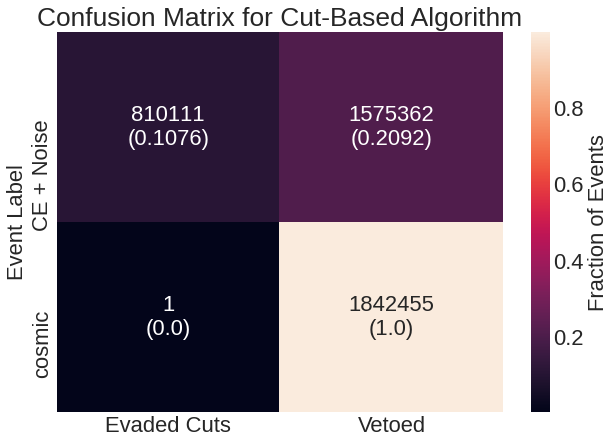

In [ ]:
cutsMatrix = np.array([[timeN/superTotal, (totN-timeN)/superTotal], [time/tot, (tot - time)/tot]])
plt.figure(figsize=(10,7));
 
annotStr = np.array([[str(round(timeN)) + '\n(' + str(round(timeN/superTotal,4)) + ')', 
                            str(round((totN-timeN))) + '\n(' + str(round((totN-timeN)/superTotal,4)) + ')'], 
                           [str(round(time)) + '\n(' + str(round(time/tot,4)) + ')', 
                            str(round(tot - time)) + '\n(' + str(round((tot - time)/tot,4)) + ')']])

ax = sns.heatmap(cutsMatrix, annot = annotStr, xticklabels=["Evaded Cuts", "Vetoed"], yticklabels=["CE + Noise", "cosmic"], fmt='.17s', cbar_kws={'label': 'Fraction of Events'});
 
ax.set(title="Confusion Matrix for Cut-Based Algorithm",
      xlabel="",
      ylabel="Event Label",);

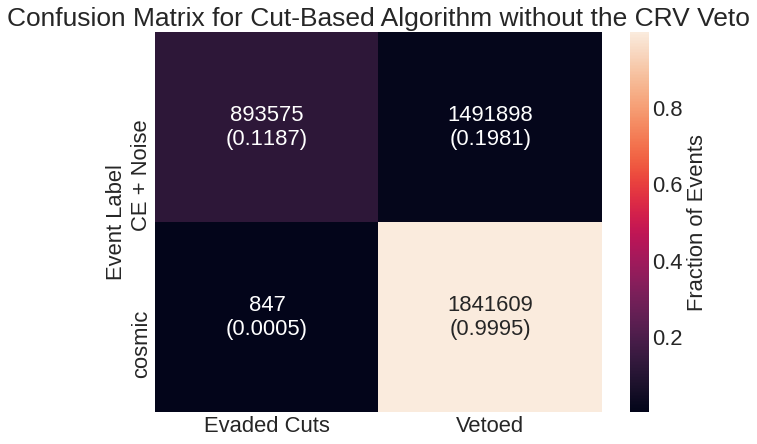

In [ ]:
cutsMatrix = np.array([[exN/superTotal, (exN-timeN)/superTotal], [ex/tot, (tot - ex)/tot]])
plt.figure(figsize=(10,7));
 
annotStr = np.array([[str(round(exN)) + '\n(' + str(round(exN/superTotal,4)) + ')', 
                            str(round((totN-exN))) + '\n(' + str(round((totN-exN)/superTotal,4)) + ')'], 
                           [str(round(ex)) + '\n(' + str(round(ex/tot,4)) + ')', 
                            str(round(tot - ex)) + '\n(' + str(round((tot - ex)/tot,4)) + ')']])

ax = sns.heatmap(cutsMatrix, annot = annotStr, xticklabels=["Evaded Cuts", "Vetoed"], yticklabels=["CE + Noise", "cosmic"], fmt='.17s', cbar_kws={'label': 'Fraction of Events'});
 
ax.set(title="Confusion Matrix for Cut-Based Algorithm without the CRV Veto",
      xlabel="",
      ylabel="Event Label",);

In [ ]:
lowLightnotVetoed = df.query('(is_high==-2) and (' + crv_time + " & " + cut_extmom+ ')')
lowLightnotVetoedSize = len(lowLightnotVetoed)
totLowLight = len(df.query(('is_high==-2')))
plt.figure(figsize=(10,7));

annotStr = [[str(lowLightnotVetoedSize) + '\n(' + str(round(lowLightnotVetoedSize/totLowLight,4)) + ')', str(totLowLight - lowLightnotVetoedSize) + '\n(' + str(round((totLowLight - lowLightnotVetoedSize)/totLowLight,4)) + ')']]

colorArray = [[lowLightnotVetoedSize/totLowLight, (totLowLight - lowLightnotVetoedSize)/totLowLight]]

ax = sns.heatmap(colorArray, annot = annotStr, xticklabels=["Evaded Cuts", "Vetoed"], yticklabels=["cosmic"], fmt='.17s', cbar_kws={'label': 'Fraction of Events'});
ax.set(title="Confusion Matrix for Cut-Based Algorithm on Low Light Yield Sample",
      xlabel="",
      ylabel="Event Label",);

In [ ]:
for i,j in zip(all_variables_list.keys(), all_variables_list.values()):
  plt.figure();

  reconstructedCE = df_time.query('is_high==-1')[i]
  rejectedCE = vetoedCE[i]  

  plt.hist([reconstructedCE, rejectedCE], bins=50, histtype='step', label=["reconstructions", "vetoes"], density=True, range=j);
  plt.title("CE/noise event distribution for " + i + " for cuts");
  plt.yscale('log');
  plt.legend(loc='best');

In [ ]:
with open(main_path+"Saved_Data/vetoedCE.pkl", "wb+") as f:
  pickle.dump([df_time, vetoedCE], f) #Dumps all the CE events

#Make plots

In [ ]:
plotted = df.query('(is_high != -1) & crvinfo__timeWindowStart>0')

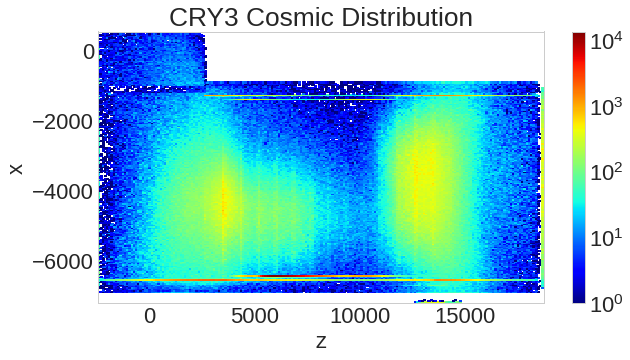

In [ ]:
plt.hist2d(plotted['crvinfomc__z'], plotted['crvinfomc__x'], bins=(200,200), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet);
plt.colorbar();
plt.title("CRY3 Cosmic Distribution");
plt.xlabel("z");
plt.ylabel("x");

In [ ]:
plotted = df.query('(is_high == -1) & crvinfo__timeWindowStart>0')

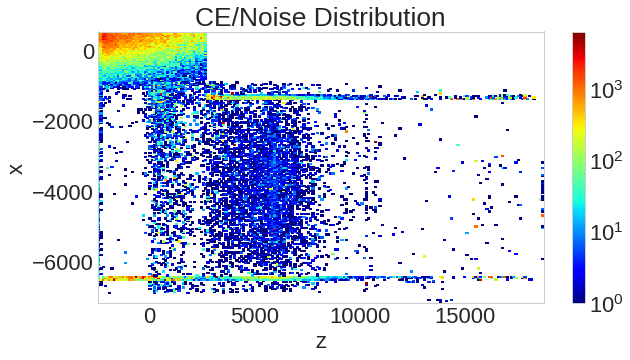

In [ ]:
plt.hist2d(plotted['crvinfomc__z'], plotted['crvinfomc__x'], bins=(200,200), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet);
plt.colorbar();
plt.title("CE/Noise Distribution");
plt.xlabel("z");
plt.ylabel("x");

#Fix and Create New Data (Don't run if loading data)

In [ ]:
variables_columns = list(variables_list.keys())
variables_columns.append('is_high')

In [ ]:
dataCuts = cut_loose

In [ ]:
dataCuts

'(deent_td > 0.577350) & (deent_td < 1.000) & (deent_d0 > -80) & (deent_d0 < 205) & ((deent_d0 + 2./deent_om) > 450) & (is_triggered) & (dequal_TrkQual > 0.8) & (dequal_TrkPID > 0.95) & (ue_status <= 0)'

In [ ]:
MLDF = df.query(dataCuts)

In [ ]:
del df

In [ ]:
def toBinary(val):
  if val != -1:
    return 1
  else:
    return 0

def toCosmic(val):
  return 1

In [ ]:
def smear(arr):
  for i in arr:
    if i[1] == 1 or i[0] < -2500:
      continue
    x = -9999999
    while x < -2500 or x > 19000:
      x = np.random.normal(i[0], 500)
    i[0] = x
  return arr

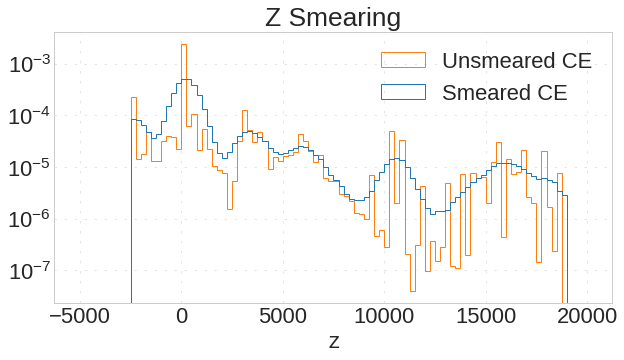

In [ ]:
MLDF['is_cosmic'] = MLDF['is_high'].apply(toBinary)
try:
  zz = smear(MLDF[['crvinfo__z','is_cosmic']].to_numpy()) #only use this cell if operating on crv variables
  oldZNoise = MLDF['crvinfo__z'][MLDF['is_cosmic']==0]
  MLDF['crvinfo__z'], MLDF['is_cosmic'] = zz[:,0], zz[:,1]
  plt.hist([MLDF['crvinfo__z'][MLDF['is_cosmic']==0],oldZNoise], bins=100, histtype='step', range=variables_list['crvinfo__z'], density=True, label=["Smeared CE", "Unsmeared CE"]);
  plt.yscale('log');
  plt.xlabel("z");
  plt.title("Z Smearing");
  plt.legend(loc='best');
except:
  pass

In [ ]:
onlyCRV = None
noCRV = None
try:
  onlyCRV = MLDF[(MLDF['crvinfo__PEs']>=-1)] #Data Filtration
  noCRV = MLDF[(MLDF['crvinfo__PEs']<-1)] #Data Filtration
  # noCRV.drop(['crvinfo__z', 'crvinfo__PEs', 'crvinfo__dT'], axis=1, inplace=True)
except:
  pass

#Create Training, Validation, and Testing Data (Don't run if loading data)

In [ ]:
noCRVCosmics = noCRV.query('is_cosmic==1')
noCRVCosmicTrain, noCRVCosmicTest, noCRVCosmicYTrain, noCRVCosmicYTest = train_test_split(noCRVCosmics.drop(columns='is_cosmic'), noCRVCosmics['is_cosmic'], test_size=0.2, random_state=1)
noCRVCosmicYTest = np.ravel(noCRVCosmicYTest).flatten()
noCRVCosmicYTrain = np.ravel(noCRVCosmicYTrain).flatten()

In [ ]:
y_noCRV = noCRV.query('is_cosmic==0')['is_cosmic']
X_noCRV = noCRV.query('is_cosmic==0').drop(columns='is_cosmic')
noCRV_X_train_df, no_CRV_X_test_df, noCRV_y_train, noCRV_y_test = train_test_split(X_noCRV, y_noCRV, test_size=0.2, random_state=1)
noCRV_X_train_df, noCRV_X_val_df, noCRV_y_train, noCRV_y_val = train_test_split(noCRV_X_train_df, noCRV_y_train, test_size=0.25, random_state=1)

noCRV_y_train = np.ravel(noCRV_y_train).flatten()
no_CRV_y_test = np.ravel(noCRV_y_test).flatten()
noCRV_y_val = np.ravel(noCRV_y_val).flatten()

In [ ]:
no_CRV_X_train_df = noCRV_X_train_df.append(noCRVCosmicTrain)
noCRV_X_val_df = noCRV_X_val_df.append(noCRVCosmicTest)
noCRV_y_train = np.append(noCRV_y_train, noCRVCosmicYTrain)
noCRV_y_val = np.append(noCRV_y_val, noCRVCosmicYTest)

In [ ]:
newdf = noCRV_X_train_df.append(noCRVCosmicTrain)

In [ ]:
noCRV_noMom_variables_list

{'de_nhits': [-2, 100],
 'deent_td': [0, 10],
 'deent_z0': [-500, 500],
 'dequal_TrkPID': [-1.1, 1.1],
 'dequal_TrkQual': [-0.1, 1.1],
 'ue_nhits': [-2, 100]}

In [ ]:
dTZPE_noMom_variables_list

{'crvinfo__PEs': [-1, 1000],
 'crvinfo__dT': [-500, 500],
 'crvinfo__z': [-5000, 20000],
 'de_nhits': [-2, 100],
 'deent_td': [0, 10],
 'deent_z0': [-500, 500],
 'dequal_TrkPID': [-1.1, 1.1],
 'dequal_TrkQual': [-0.1, 1.1],
 'ue_nhits': [-2, 100]}

In [ ]:
noCRVscaler = StandardScaler().fit(noCRV[list(noCRV_noMom_variables_list.keys())])
newdfScaled = noCRVscaler.transform(newdf[list(noCRV_noMom_variables_list.keys())])
noCRV_X_val = noCRVscaler.transform(noCRV_X_val_df[list(noCRV_noMom_variables_list.keys())])

In [ ]:
with open(main_path+"Saved_Data/noCoincidenceTrainer.pkl", "wb+") as f:
  pickle.dump([noCRV_y_train, noCRV_y_val, noCRVscaler, newdfScaled, noCRV_X_val, newdf, noCRV_X_val_df], f)
with open(main_path+"Saved_Data/noCoincidenceTestingCE.pkl", "wb+") as f:
  pickle.dump([noCRV_y_test, no_CRV_X_test_df], f)

In [ ]:
CRVCosmics = onlyCRV.query('is_cosmic==1')
CRVCosmicTrain, CRVCosmicTest, CRVCosmicYTrain, CRVCosmicYTest = train_test_split(CRVCosmics.drop(columns='is_cosmic'), CRVCosmics['is_cosmic'], test_size=0.2, random_state=1)
CRVCosmicYTest = np.ravel(CRVCosmicYTest).flatten()
CRVCosmicYTrain = np.ravel(CRVCosmicYTrain).flatten()

In [ ]:
y_CRV = onlyCRV.query('is_cosmic==0')['is_cosmic']
X_CRV = onlyCRV.query('is_cosmic==0').drop(columns='is_cosmic')
CRV_X_train_df, CRV_X_test_df, CRV_y_train, CRV_y_test = train_test_split(X_CRV, y_CRV, test_size=0.2, random_state=1)
CRV_X_train_df, CRV_X_val_df, CRV_y_train, CRV_y_val = train_test_split(CRV_X_train_df, CRV_y_train, test_size=0.25, random_state=1)

CRV_y_train = np.ravel(CRV_y_train).flatten()
CRV_y_test = np.ravel(CRV_y_test).flatten()
CRV_y_val = np.ravel(CRV_y_val).flatten()

In [ ]:
CRV_X_train_df = CRV_X_train_df.append(CRVCosmicTrain)
CRV_X_val_df = CRV_X_val_df.append(CRVCosmicTest)
CRV_y_train = np.append(CRV_y_train, CRVCosmicYTrain)
CRV_y_val = np.append(CRV_y_val, CRVCosmicYTest)

In [ ]:
CRVscaler = StandardScaler().fit(onlyCRV[list(dTZPE_noMom_variables_list.keys())])
CRV_X_train = CRVscaler.transform(CRV_X_train_df[list(dTZPE_noMom_variables_list.keys())])
CRV_X_val = CRVscaler.transform(CRV_X_val_df[list(dTZPE_noMom_variables_list.keys())])

In [ ]:
with open(main_path+"Saved_Data/CoincidenceTrainer.pkl", "wb+") as f:
  pickle.dump([CRV_y_train, CRV_y_val, CRVscaler, CRV_X_train, CRV_X_val, CRV_X_train_df, CRV_X_val_df], f)
with open(main_path+"Saved_Data/CoincidenceTestingCE.pkl", "wb+") as f:
  pickle.dump([CRV_y_test, CRV_X_test_df], f)

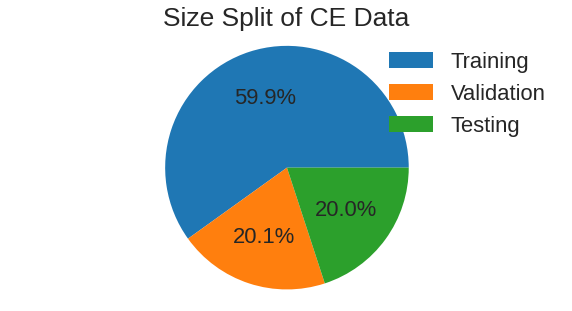

In [ ]:
labels = "Training","Validation","Testing"
sizes = len(noCRV_X_train_df)/len(X_noCRV), len(noCRV_X_val_df)/len(X_noCRV), len(no_CRV_X_test_df)/len(X_noCRV)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', labeldistance=None);
plt.legend();
plt.gca().axis('equal');
plt.title("Size Split of CE Data");

#Make correlation plots

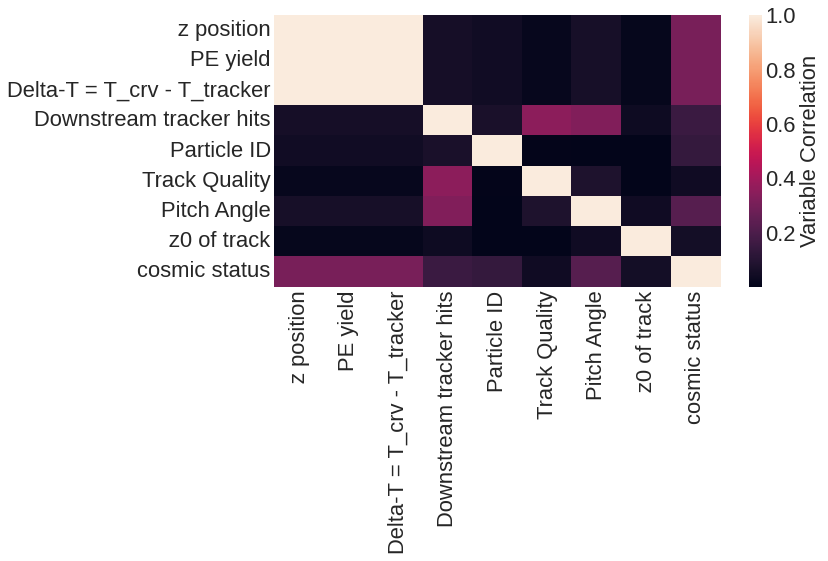

In [ ]:
corr = MLDF[list(dTZPE_noMom_variables_list.keys()) + ["is_cosmic"]].corr();
sns.heatmap(abs(corr), xticklabels=list(map(translation.get, corr.columns.values)), yticklabels=list(map(translation.get, corr.columns.values)), cbar_kws={'label': 'Variable Correlation'});

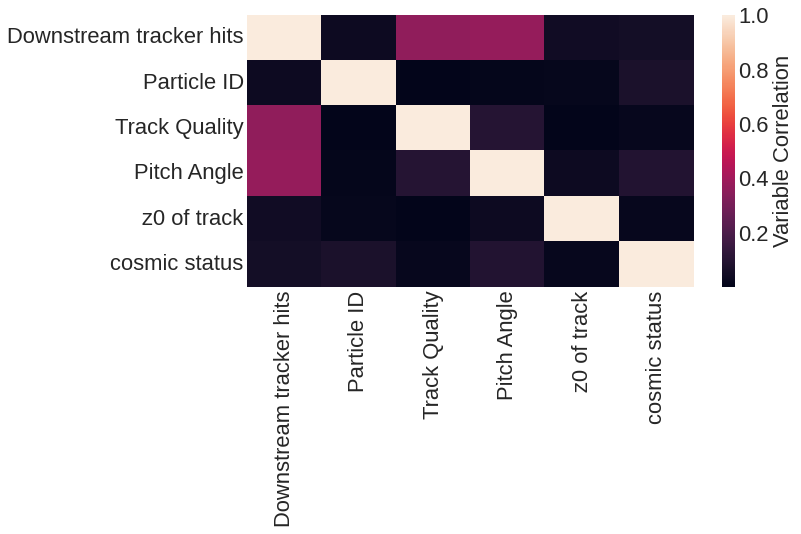

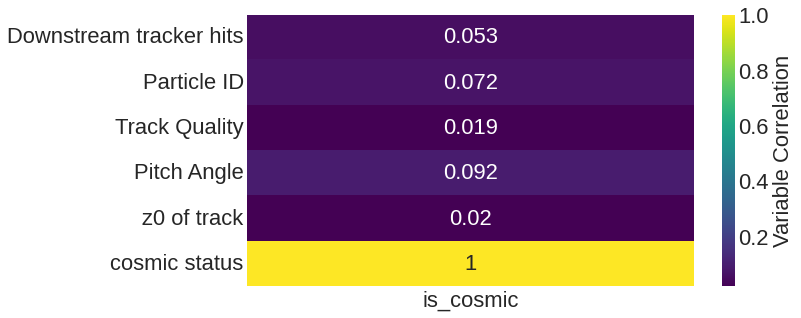

In [ ]:
corr = noCRV[list(noCRV_noMom_variables_list.keys()) + ["is_cosmic"]].corr();
sns.heatmap(abs(corr), xticklabels=list(map(translation.get, corr.columns.values)), yticklabels=list(map(translation.get, corr.columns.values)), cbar_kws={'label': 'Variable Correlation'});
plt.figure();
sns.heatmap(abs(corr[['is_cosmic']]), yticklabels=list(map(translation.get, corr.columns.values)), fmt='.2g', cmap='viridis', annot=True, cbar_kws={'label': 'Variable Correlation'});

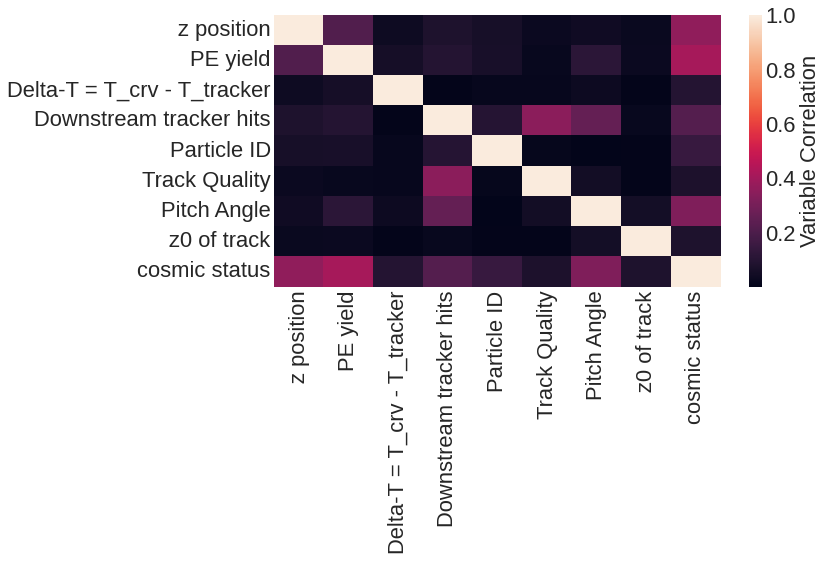

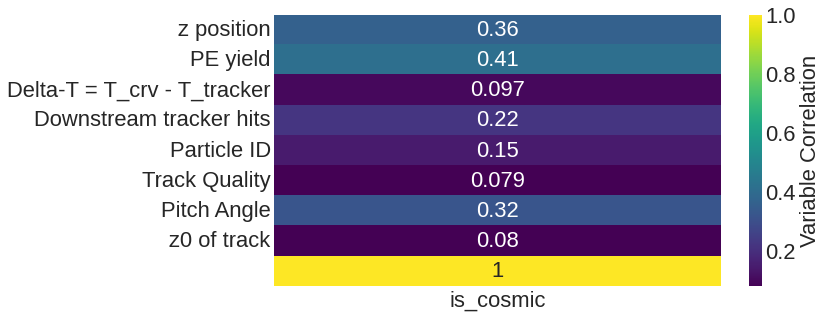

In [ ]:
corr = onlyCRV[list(dTZPE_noMom_variables_list.keys()) + ["is_cosmic"]].corr();
sns.heatmap(abs(corr), xticklabels=list(map(translation.get, corr.columns.values)), yticklabels=list(map(translation.get, corr.columns.values)), cbar_kws={'label': 'Variable Correlation'});
plt.figure();
sns.heatmap(abs(corr[['is_cosmic']]), yticklabels=list(map(translation.get, corr.columns.values[:-1])), fmt='.2g', cmap='viridis', annot=True, cbar_kws={'label': 'Variable Correlation'});

#Model for Coincidence Data Only

In [ ]:
fileopener = open(main_path+"/Saved_Data/CoincidenceTrainer.pkl", "rb")
CRV_y_train, CRV_y_val, CRVscaler, CRV_X_train, CRV_X_val, CRV_X_train_df, CRV_X_val_df = pickle.load(fileopener)

In [ ]:
cinnamonBagel = MLAnalyzer(dTZPE_noMom_variables_list, CRV_X_train, CRV_y_train, CRV_X_val, CRV_y_val, None, None, scaler=CRVscaler, droprate=0.3)

In [ ]:
cinnamonBagel.trainModel(False, 4,6,100, epoch=800, modelPatience=100)

INFO:weightwatcher:

python      version 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
numpy       version 1.19.5
tensforflow version 2.6.0
keras       version 2.6.0


fitting model with width= 36 	depth= 8 	size= 100
298 total neurons
Epoch 1/800
3756/3756 [==============================] - 14s 3ms/step - loss: 0.0899 - accuracy: 0.9624 - val_loss: 0.0356 - val_accuracy: 0.9883


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Assuming nested distributions


Assuming nested distributions


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Assuming nested distributions
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Current alpha value of 2.557611446359497
Epoch 2/800
3756/3756 [==============================] - 13s 3ms/step - loss: 0.0349 - accuracy: 0.9888 - val_loss: 0.0303 - val_accuracy: 0.9900


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Assuming nested distributions
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Current alpha value of 2.3998195307901957
Epoch 3/800
3756/3756 [==============================] - 14s 4ms/step - loss: 0.0318 - accuracy: 0.9896 - val_loss: 0.0283 - val_accuracy: 0.9904


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Assuming nested distributions


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Assuming nested distributions
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Current alpha value of 2.293286605891572
Epoch 4/800
3756/3756 [==============================] - 13s 3ms/step - loss: 0.0304 - accuracy: 0.9901 - val_loss: 0.0286 - val_accuracy: 0.9901


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Assuming nested distributions


Assuming nested distributions


Assuming nested distributions


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Assuming nested distributions
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Current alpha value of 2.1669785513663236
Epoch 5/800
3756/3756 [==============================] - 14s 4ms/step - loss: 0.0295 - accuracy: 0.9902 - val_loss: 0.0265 - val_accuracy: 0.9914


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Assuming nested distributions
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Current alpha value of 2.1678559644638935
Epoch 6/800
3756/3756 [==============================] - 13s 4ms/step - loss: 0.0290 - accuracy: 0.9904 - val_loss: 0.0256 - val_accuracy: 0.9911


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Assuming nested distributions


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Assuming nested distributions
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Current alpha value of 2.158695974275139
Epoch 7/800
3756/3756 [==============================] - 14s 4ms/step - loss: 0.0279 - accuracy: 0.9906 - val_loss: 0.0268 - val_accuracy: 0.9906


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Assuming nested distributions
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Current alpha value of 2.095718403099319


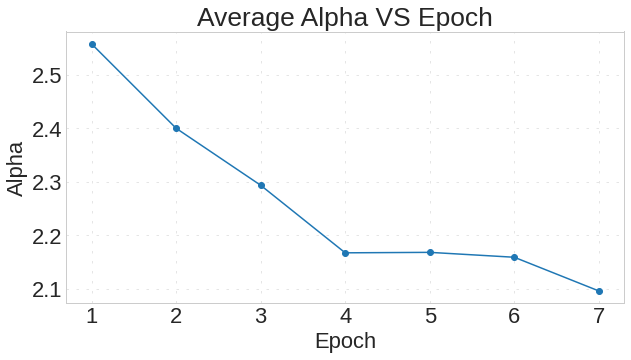

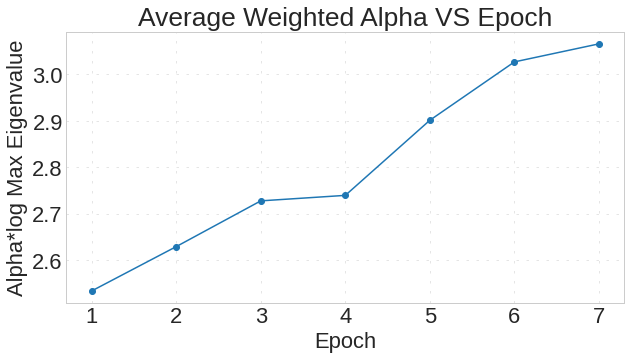

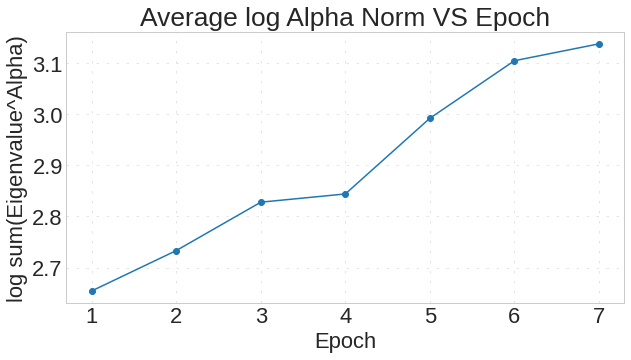

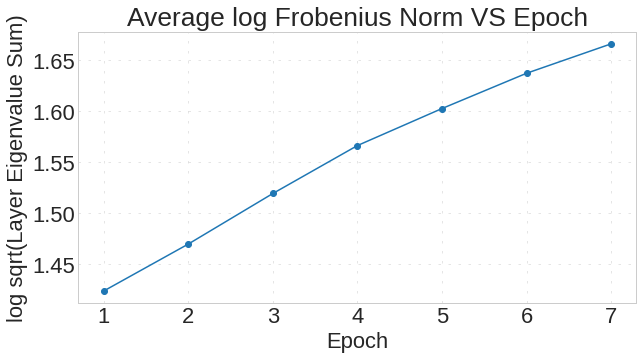

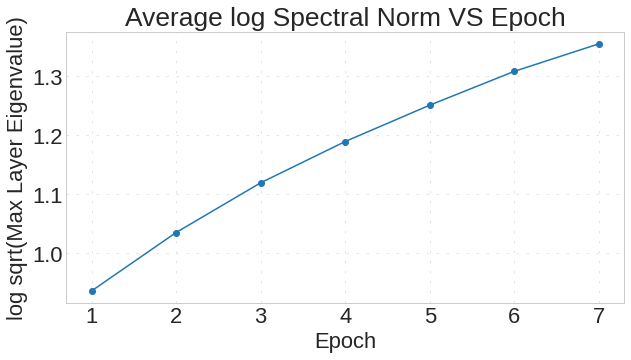

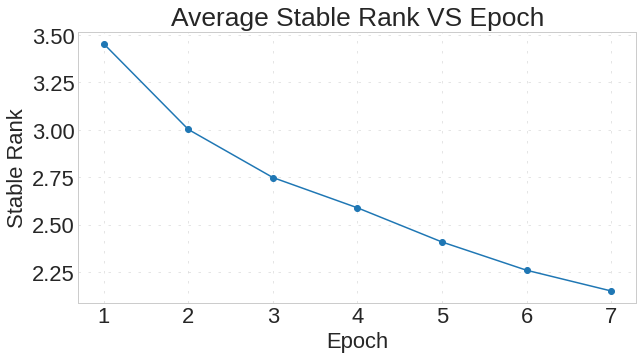

In [ ]:
cinnamonBagel.plotWeights()

In [ ]:
%%capture
cinnamonDetails, _ = cinnamonBagel.weightAnalysis()

INFO:weightwatcher:

python      version 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
numpy       version 1.19.5
tensforflow version 2.6.0
keras       version 2.6.0
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img


In [ ]:
cinnamonDetails

layer_id  name   D    M  ...  tail_var_vec_entropy       warning  xmax xmin
0        0  None 0.2  9.0  ...                   0.0  over-trained  15.3  0.3
1        1  None 0.3  9.0  ...                   0.0  over-trained  16.5  0.3
2        3  None 0.1 36.0  ...                   0.0                53.9  1.5
3        5  None 0.1 36.0  ...                   0.0                35.7  1.7
4        7  None 0.1 36.0  ...                   0.0                25.0  1.5
5        9  None 0.1 36.0  ...                   0.0                29.3  1.4
6       11  None 0.1 36.0  ...                   0.0                31.4  1.8
7       13  None 0.1 36.0  ...                   0.0  over-trained  34.0  1.0
8       14  None nan  1.0  ...                   nan                 4.1  nan

[9 rows x 40 columns]

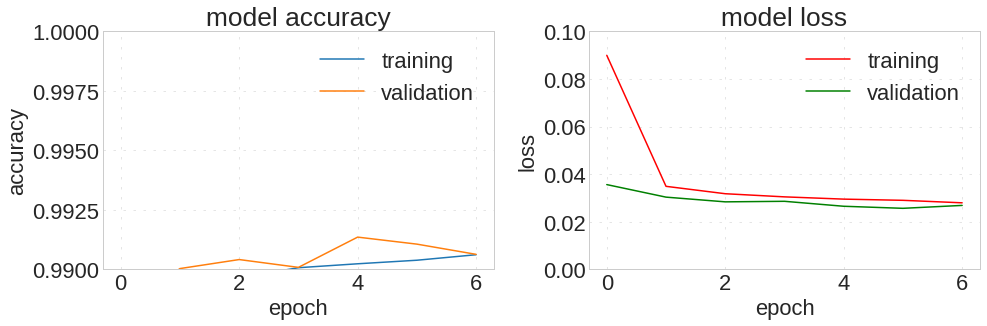

In [ ]:
cinnamonBagel.plotAcc()

In [ ]:
cinnamonBagel.save("cinnamonBagelsmallBatch3")

TypeError: ignored

#Model for Events Outside the CRV

In [ ]:
fileopener = open(main_path+"/Saved_Data/noCoincidenceTrainer.pkl", "rb")
noCRV_y_train, noCRV_y_val, noCRVscaler, noCRV_X_train, noCRV_X_val, noCRV_X_train_df, noCRV_X_val_df = pickle.load(fileopener)

In [ ]:
plainBagel = MLAnalyzer(noCRV_noMom_variables_list, noCRV_X_train, noCRV_y_train, noCRV_X_val, noCRV_y_val, None, None, scaler=noCRVscaler, droprate=0.3)

In [ ]:
plainBagel.trainModel(False, 4,6,100, epoch=800, modelPatience=800)

INFO:weightwatcher:

python      version 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
numpy       version 1.19.5
tensforflow version 2.6.0
keras       version 2.6.0


fitting model with width= 24 	depth= 8 	size= 100
199 total neurons
Epoch 1/800
6557/6557 [==============================] - 21s 3ms/step - loss: 0.0535 - accuracy: 0.9890 - val_loss: 0.0357 - val_accuracy: 0.9924


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


xmin progress: 21%

Assuming nested distributions


xmin progress: 26%

Assuming nested distributions


Assuming nested distributions
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Assuming nested distributions
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Current alpha value of 3.3295845519712186
Epoch 2/800
6557/6557 [==============================] - 19s 3ms/step - loss: 0.0427 - accuracy: 0.9905 - val_loss: 0.0343 - val_accuracy: 0.9928


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Assuming nested distributions


xmin progress: 21%

Assuming nested distributions


xmin progress: 30%

Assuming nested distributions


xmin progress: 26%

Assuming nested distributions
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Assuming nested distributions
Not enough data. Returning nan


No valid fits found.
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Current alpha value of 2.376423328981608
Epoch 3/800
6557/6557 [==============================] - 19s 3ms/step - loss: 0.0414 - accuracy: 0.9909 - val_loss: 0.0339 - val_accuracy: 0.9928


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Assuming nested distributions


Assuming nested distributions
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Assuming nested distributions
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Current alpha value of 2.9459660302081927
Epoch 4/800
6557/6557 [==============================] - 19s 3ms/step - loss: 0.0409 - accuracy: 0.9909 - val_loss: 0.0344 - val_accuracy: 0.9930


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


Assuming nested distributions


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Assuming nested distributions
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Current alpha value of 2.5111663640957476
Epoch 5/800
6557/6557 [==============================] - 19s 3ms/step - loss: 0.0406 - accuracy: 0.9910 - val_loss: 0.0335 - val_accuracy: 0.9932


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Assuming nested distributions


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Assuming nested distributions
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Current alpha value of 2.416820612814827
Epoch 6/800
6557/6557 [==============================] - 22s 3ms/step - loss: 0.0404 - accuracy: 0.9910 - val_loss: 0.0334 - val_accuracy: 0.9932


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


xmin progress: 52%

Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


xmin progress: 08%

Assuming nested distributions


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Assuming nested distributions
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Current alpha value of 2.2031696603478936
Epoch 7/800
6557/6557 [==============================] - 21s 3ms/step - loss: 0.0402 - accuracy: 0.9910 - val_loss: 0.0332 - val_accuracy: 0.9931


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


xmin progress: 47%

Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


xmin progress: 08%

Assuming nested distributions


Assuming nested distributions


xmin progress: 21%

Assuming nested distributions


xmin progress: 43%

Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Assuming nested distributions
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Current alpha value of 2.1609435963503416
Epoch 8/800
6557/6557 [==============================] - 22s 3ms/step - loss: 0.0400 - accuracy: 0.9911 - val_loss: 0.0330 - val_accuracy: 0.9931


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img
Assuming nested distributions
Assuming nested distributions


Assuming nested distributions


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Assuming nested distributions
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Current alpha value of 2.1460307801029455
Epoch 9/800
6557/6557 [==============================] - 20s 3ms/step - loss: 0.0397 - accuracy: 0.9911 - val_loss: 0.0325 - val_accuracy: 0.9932


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img
Assuming nested distributions
Assuming nested distributions


Assuming nested distributions


xmin progress: 39%

Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Assuming nested distributions
Assuming nested distributions


xmin progress: 26%

Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Assuming nested distributions
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Current alpha value of 2.100191340241459
Epoch 10/800
6557/6557 [==============================] - 19s 3ms/step - loss: 0.0398 - accuracy: 0.9911 - val_loss: 0.0326 - val_accuracy: 0.9933


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img
Assuming nested distributions
Assuming nested distributions


Assuming nested distributions


Assuming nested distributions


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Assuming nested distributions


Assuming nested distributions


Assuming nested distributions


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Assuming nested distributions
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Current alpha value of 2.0365365806533684


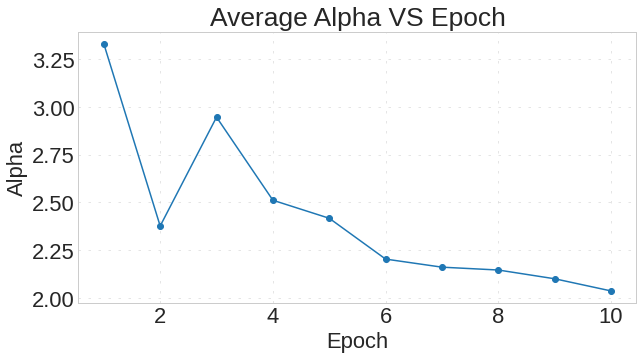

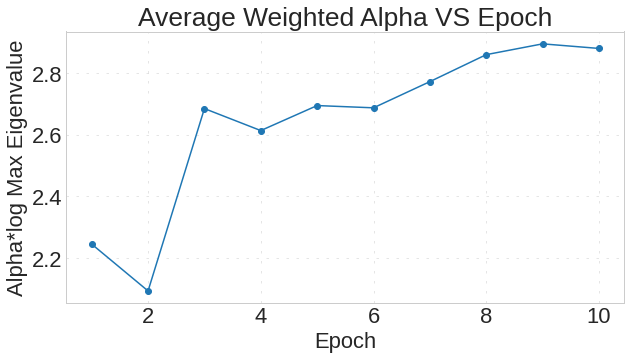

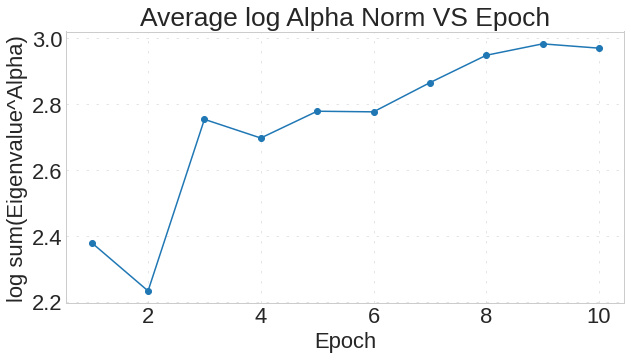

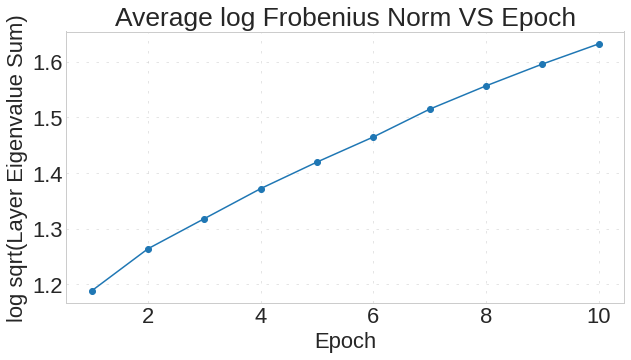

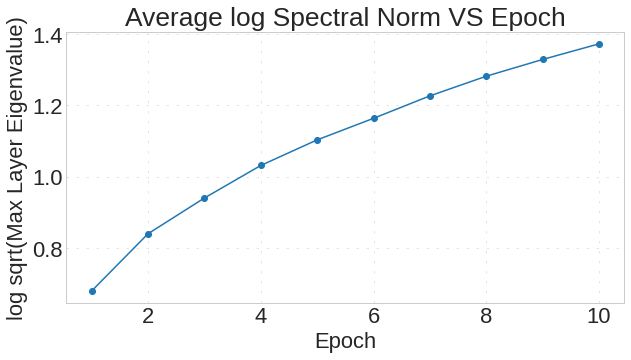

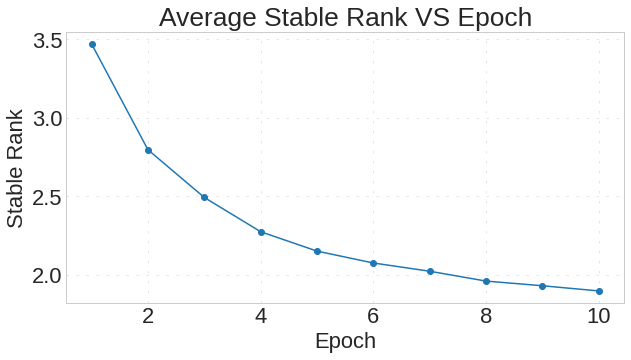

In [ ]:
plainBagel.plotWeights()

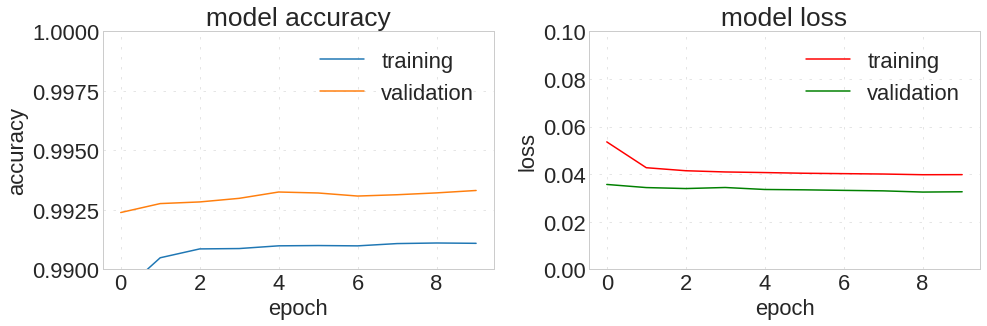

In [ ]:
plainBagel.plotAcc()

In [ ]:
plainBagel.save("PlainBagelsmallBatch3")

#Loading CRY4 Cosmic Data (Don't Run if Loading Predictions)

In [20]:
fileopener = open(main_path+"/Saved_Data/noCoincidenceTrainer.pkl", "rb")
noCRV_y_train, noCRV_y_val, noCRVscaler, noCRV_X_train, noCRV_X_val, noCRV_X_train_df, noCRV_X_val_df = pickle.load(fileopener)

In [21]:
fileopener = open(main_path+"/Saved_Data/CoincidenceTrainer.pkl", "rb")
CRV_y_train, CRV_y_val, CRVscaler, CRV_X_train, CRV_X_val, CRV_X_train_df, CRV_X_val_df = pickle.load(fileopener)

In [22]:
del noCRV_y_train, noCRV_y_val,noCRV_X_train, noCRV_X_val, noCRV_X_train_df, noCRV_X_val_df, CRV_y_train, CRV_y_val, CRV_X_train, CRV_X_val, CRV_X_train_df, CRV_X_val_df

In [23]:
variousYields = pd.read_hdf(main_path + "root_files_cry4/cry4df.h5").query(cut_loose)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


#CRY4 Distributions

In [ ]:
plotted = variousYields.query('(is_high == 1 or is_high == 0) & crvinfo__timeWindowStart>0')

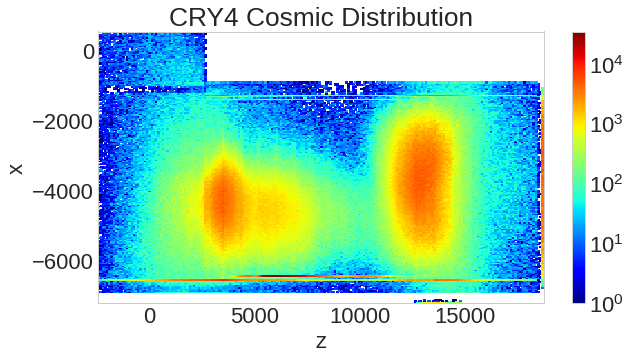

In [ ]:
plt.hist2d(plotted['crvinfomc__z'], plotted['crvinfomc__x'], bins=(200,200), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet);
plt.colorbar();
plt.title("CRY4 Cosmic Distribution");
plt.xlabel("z");
plt.ylabel("x");

In [ ]:
del plotted

#Separate into coincidence and noncoincidence(Don't Run if Loading Predictions)

In [24]:
coincidenceYields = variousYields.query("crvinfo__PEs >= -1")[list(all_variables_list.keys()) + ["is_high", "lyield", "de_status", "ue_status", "is_triggered", "crvinfo__timeWindowStart", "de_t0"]]
noCoincidenceYields = variousYields.query("crvinfo__PEs < -1")[list(all_variables_list.keys()) + ["is_high", "lyield", "de_status", "ue_status", "is_triggered", "crvinfo__timeWindowStart", "de_t0"]]

In [25]:
del variousYields

#Loading Models and Utils Class

In [ ]:
class Utils:
  
  def __init__(self):
    self.LIVETIME_LO=1.36E8+5.09E7
    self.LIVETIME_HI=5.49E6 
    self.LIVETIME_MU2E=3.46E6

  def getNormBackground(self, df, cuts, scale):

  # scale - to account for a larger momentum window 

    raw_count_hi = len(df.query('is_high==1 & %s' % cuts))
    raw_count_lo = len(df.query('is_high==0 & %s' % cuts))

    ave_hi = raw_count_hi/self.LIVETIME_HI*self.LIVETIME_MU2E/scale
    ave_lo = raw_count_lo/self.LIVETIME_LO*self.LIVETIME_MU2E/scale
    ave = ave_hi + ave_lo
  
    err_hi = math.sqrt(raw_count_hi)/self.LIVETIME_HI*self.LIVETIME_MU2E/scale
    err_lo = math.sqrt(raw_count_lo)/self.LIVETIME_LO*self.LIVETIME_MU2E/scale
    err = math.sqrt(err_hi**2 + err_lo**2)

    return (ave, err, ave_hi, ave_lo, err_hi, err_lo)
  
  def printLiveTimes(self):
    print("LIVETIME_MU2E: %e" % self.LIVETIME_MU2E)
    print("LIVETIME_HI: %e" % self.LIVETIME_HI)
    print("LIVETIME_LO: %e" % self.LIVETIME_LO)

In [35]:
cinnamonBagel = MLAnalyzer()
cinnamonBagel.load('cinnamonBagelsmallBatch2')

plainBagel = MLAnalyzer()
plainBagel.load('PlainBagelsmallBatch2')

#Predict CRY4 Data (Don't run if loading Predictions)

In [27]:
dropout = 1 #Set this to a large number if you want to use dropout statistics

In [36]:
totalPredictions = []

coincidenceYields[list(dTZPE_noMom_variables_list.keys())] = CRVscaler.transform(coincidenceYields[list(dTZPE_noMom_variables_list.keys())])
noCoincidenceYields[list(noCRV_noMom_variables_list.keys())] = noCRVscaler.transform(noCoincidenceYields[list(noCRV_noMom_variables_list.keys())])

for i in range(dropout):
  print("starting iteration", i + 1)
  temp1 = cinnamonBagel.model.predict(coincidenceYields[list(dTZPE_noMom_variables_list.keys())])

  temp2 = plainBagel.model.predict(noCoincidenceYields[list(noCRV_noMom_variables_list.keys())])

  totalPredictions.append( np.concatenate((temp1, temp2)) )

coincidenceYields[list(dTZPE_noMom_variables_list.keys())] = CRVscaler.inverse_transform(coincidenceYields[list(dTZPE_noMom_variables_list.keys())]) #resets values back to their original values
noCoincidenceYields[list(noCRV_noMom_variables_list.keys())] = noCRVscaler.inverse_transform(noCoincidenceYields[list(noCRV_noMom_variables_list.keys())])

starting iteration 1


In [37]:
totalPredict = noCoincidenceYields.append(coincidenceYields).reset_index(drop=True)

In [38]:
totalPredict['Predictions'] = np.mean(np.array(totalPredictions),axis=0)
totalPredict['Uncertainty'] = np.std(np.array(totalPredictions),axis=0)

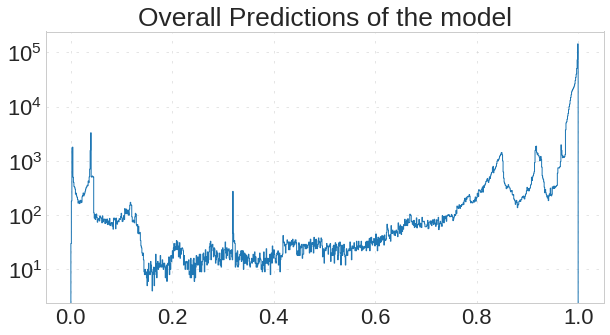

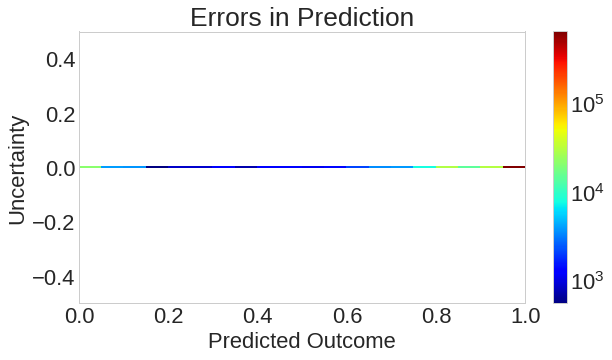

In [39]:
plt.hist(np.mean(np.array(totalPredictions),axis=0), bins=1000, histtype='step');
plt.yscale('log');
plt.title("Overall Predictions of the model");
plt.figure();
plt.hist2d(totalPredict['Predictions'], totalPredict['Uncertainty'], bins=(20,200), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet);
plt.colorbar();
plt.title("Errors in Prediction");
plt.xlabel("Predicted Outcome");
plt.ylabel("Uncertainty");

In [43]:
totalPredict.query(cut_extmom + "and Predictions < 0.001")

crvinfo__x  crvinfo__y  crvinfo__z  ...  de_t0  Predictions  Uncertainty
51531      -3904.0      2707.2      4106.2  ...  872.3          0.0          0.0
60747      -3904.0      2698.4      3671.7  ...  782.9          0.0          0.0
131754     -3904.0      2701.3      6657.1  ...  769.2          0.0          0.0
616113     -3904.0      2708.2      5015.4  ...  767.0          0.0          0.0
625207     -3904.0      2704.3      9634.7  ...  803.9          0.0          0.0
641062     -3904.0      2705.1      6426.1  ...  802.0          0.0          0.0
641686     -3904.0      2692.5      4350.7  ...  741.8          0.0          0.0
648890     -3904.0      2717.0      3444.8  ...  840.2          0.0          0.0

[8 rows x 24 columns]

In [ ]:
import tables
tables.file._open_files.close_all()

In [ ]:
totalPredict.to_hdf(main_path + "Saved_Data/cry4DF.h5", key='df', mode='w') #do this if didn't do MC dropout

In [ ]:
totalPredict.to_hdf(main_path + "Saved_Data/cry4DF_MC_Dropped.h5", key='df') #do this if mc dropout

In [ ]:
del coincidenceYields, noCoincidenceYields

#Load Predicted Data

In [ ]:
totalPredict = pd.read_hdf(main_path + "Saved_Data/cry4DF.h5", key='df', mode='r')

In [ ]:
totalPredictMC = pd.read_hdf(main_path + "Saved_Data/cr4DF_MC_Dropped.h5", key='df', mode='r')

#CRY4 Cosmic Analysis

In [33]:
yieldNums = {}
for i in totalPredict['lyield']:
  yieldNums[i] = True

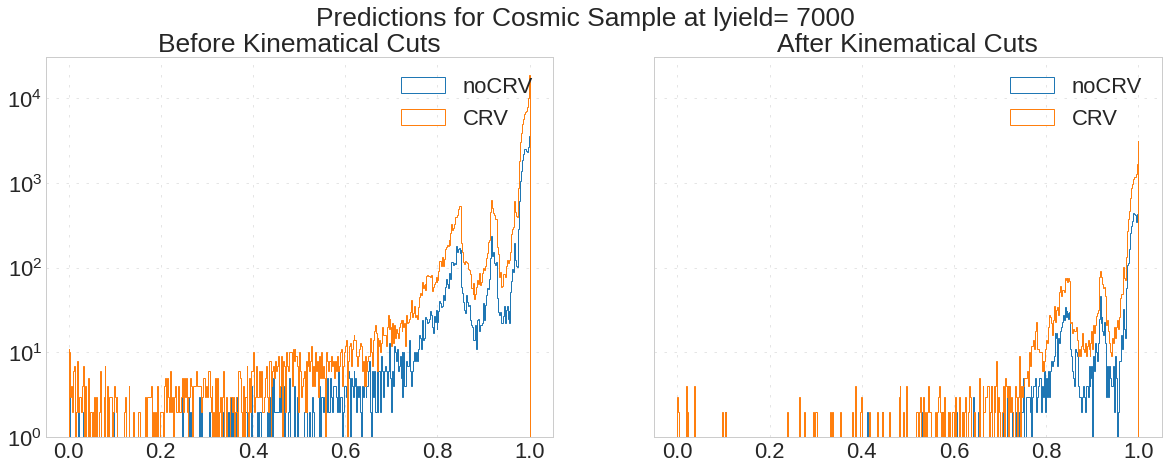

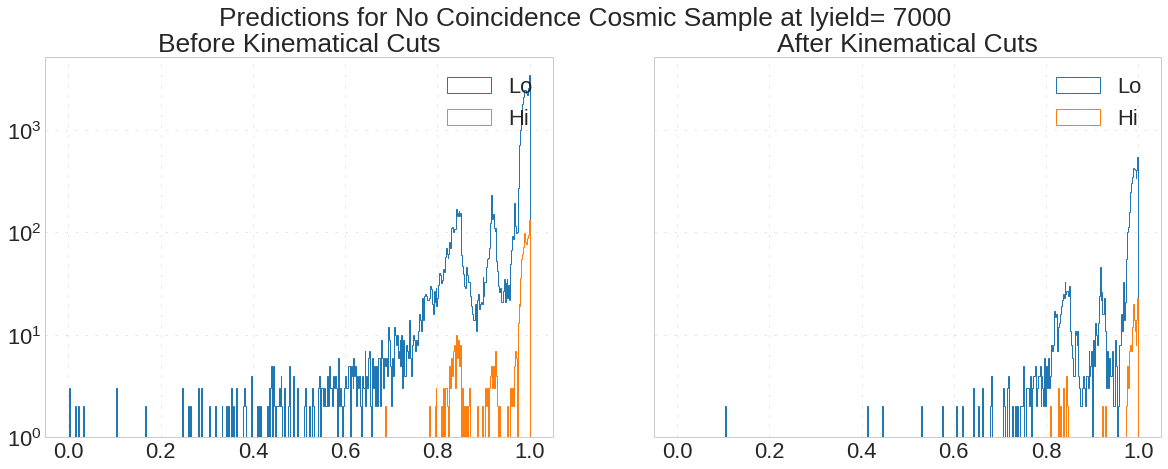

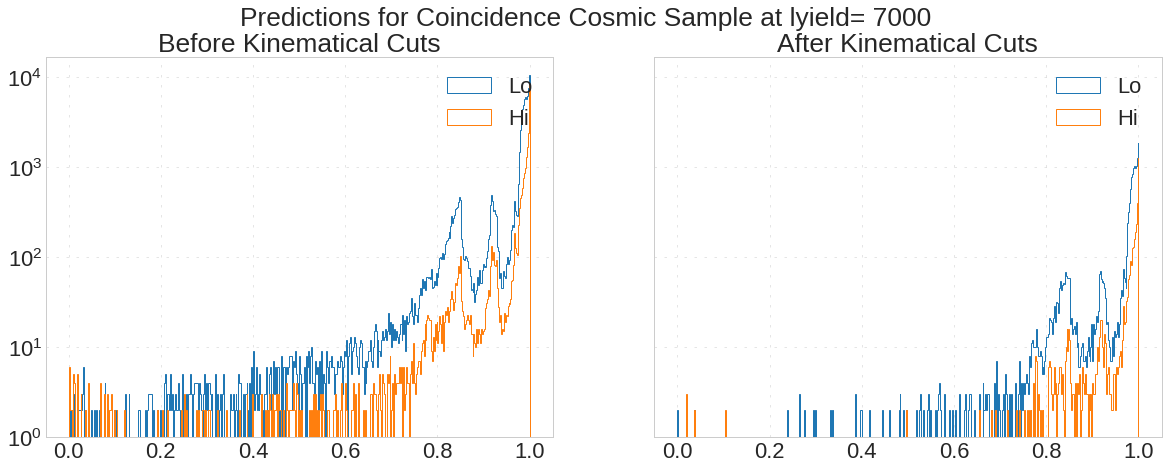

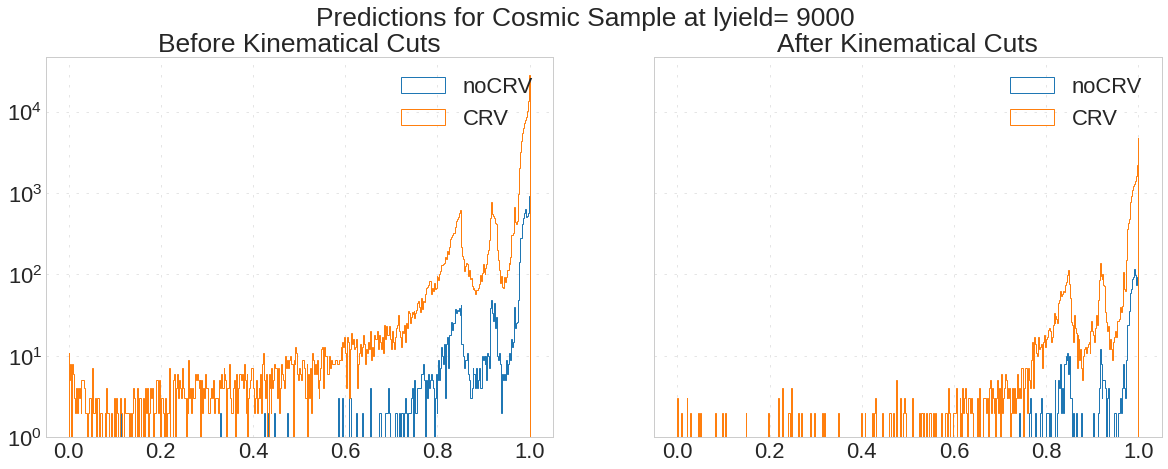

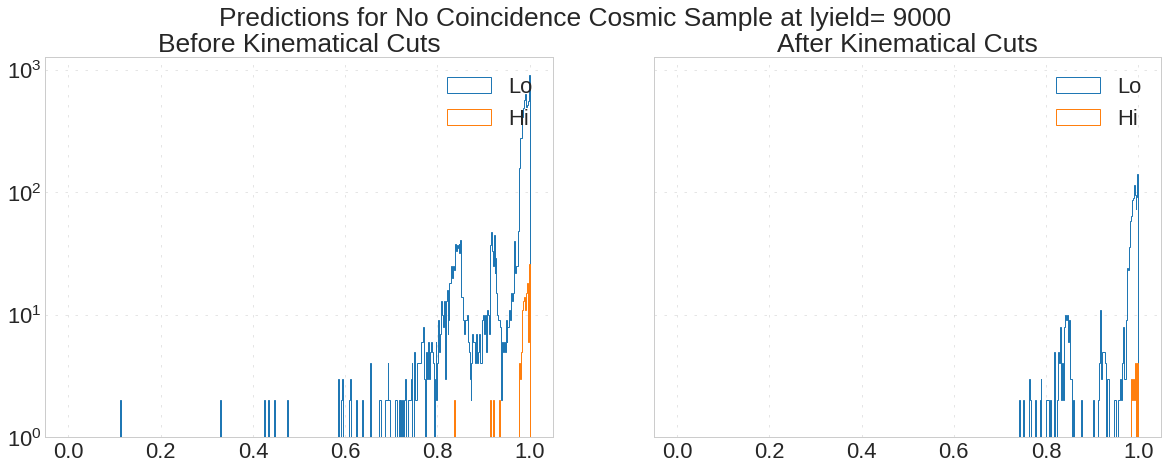

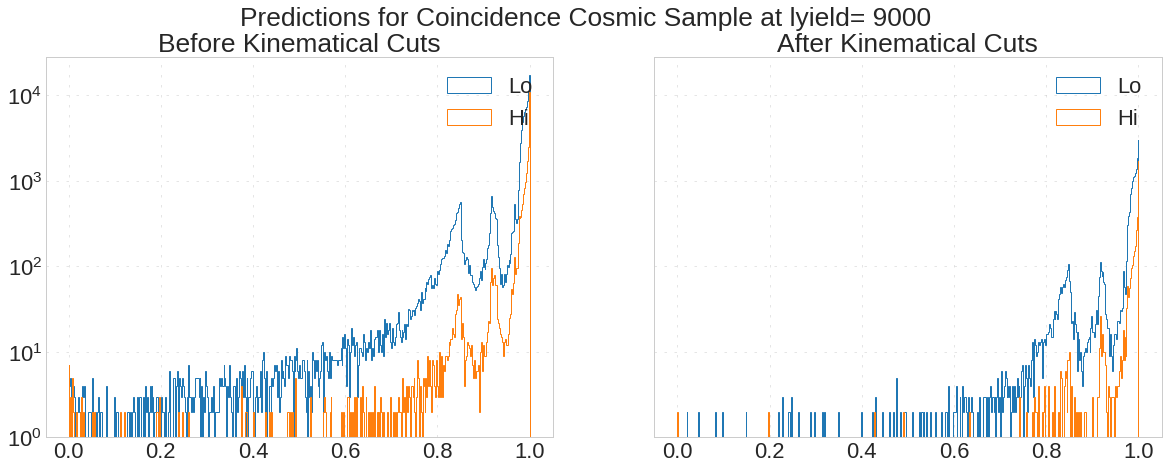

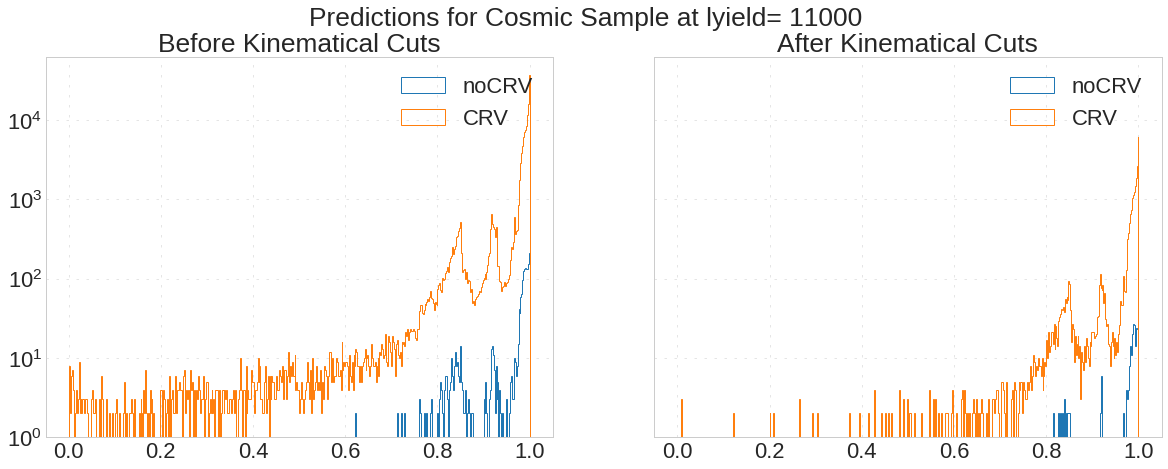

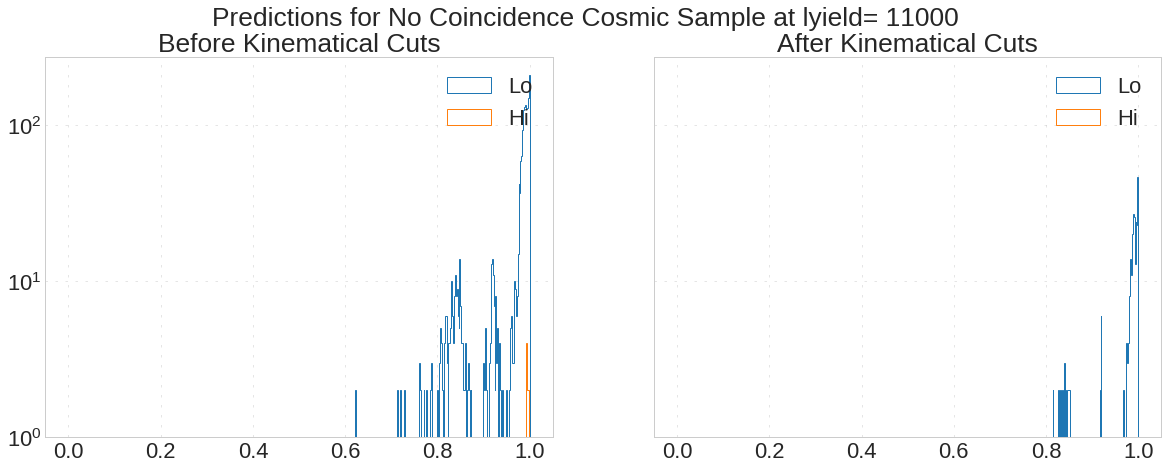

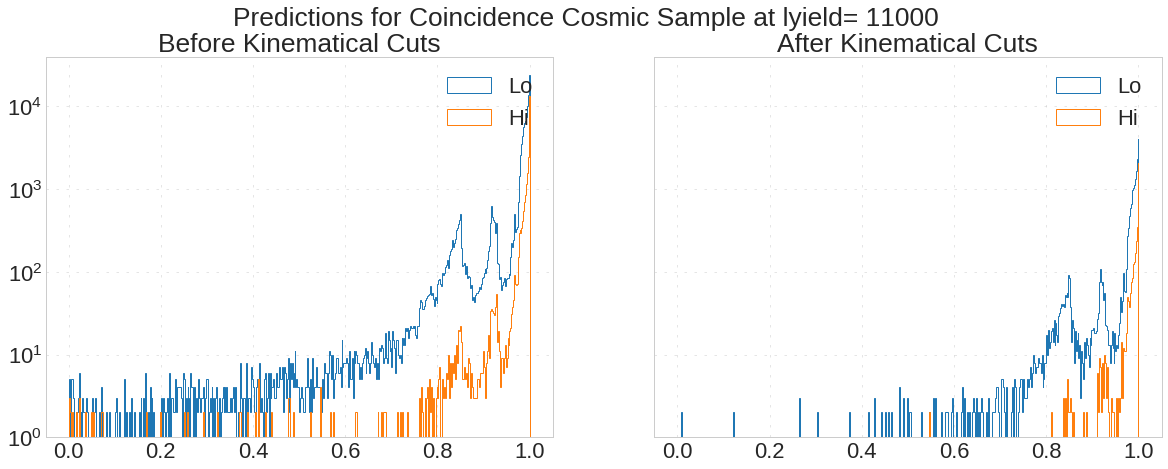

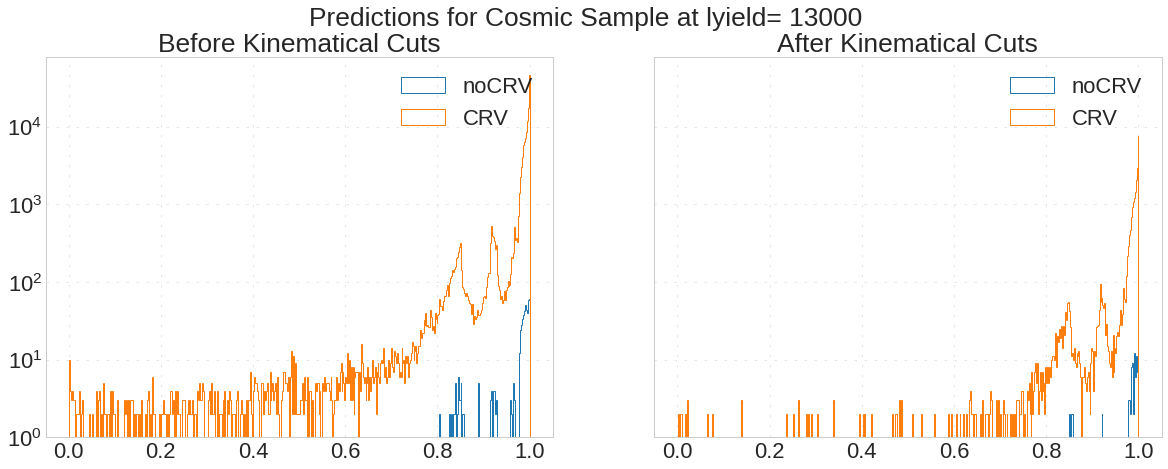

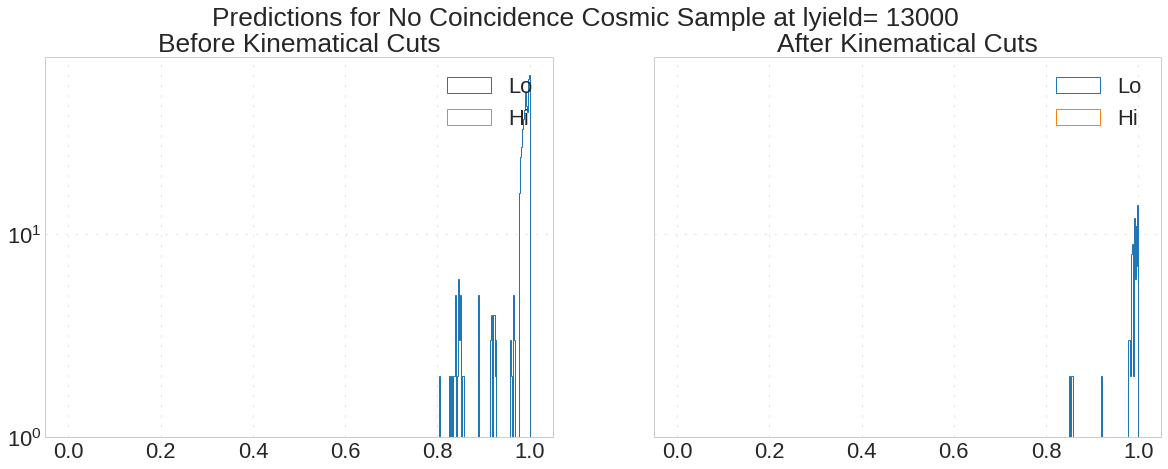

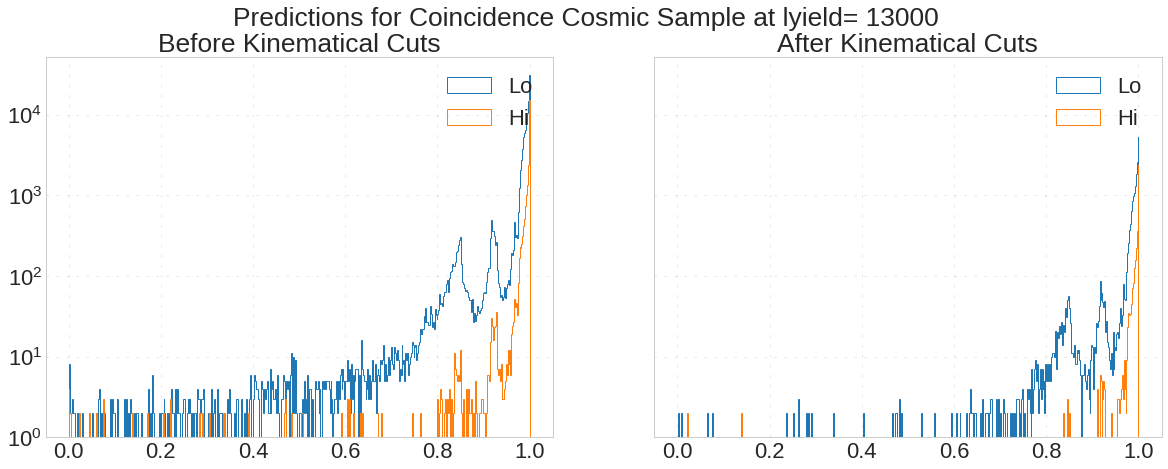

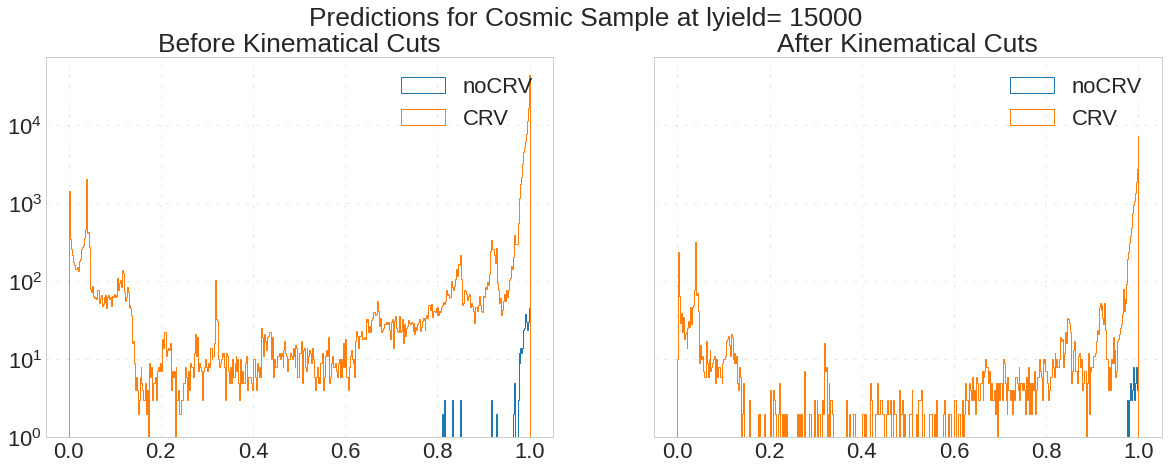

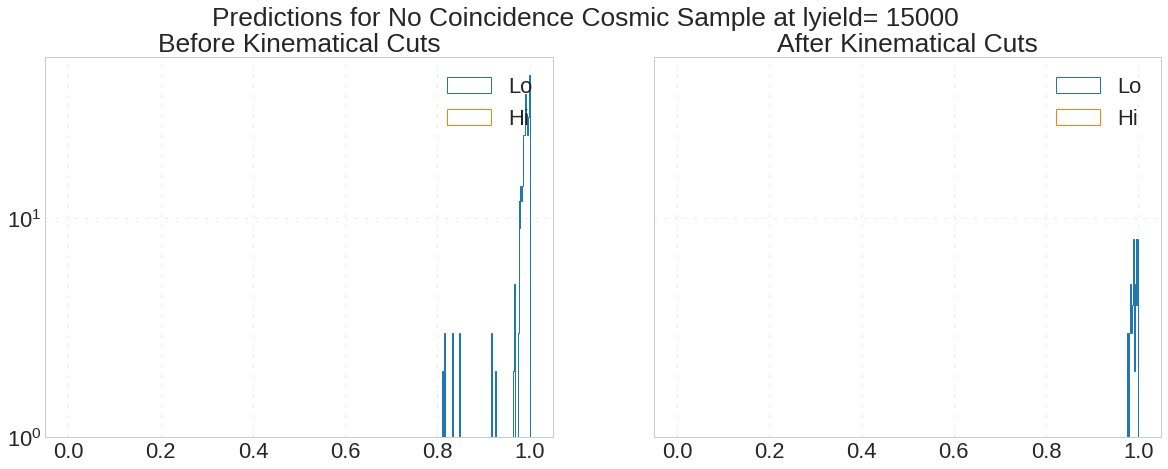

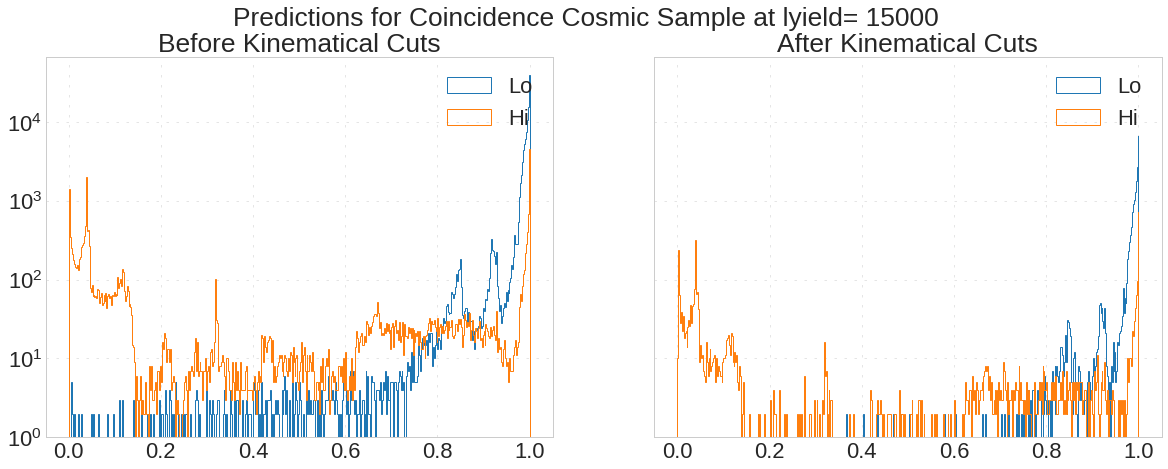

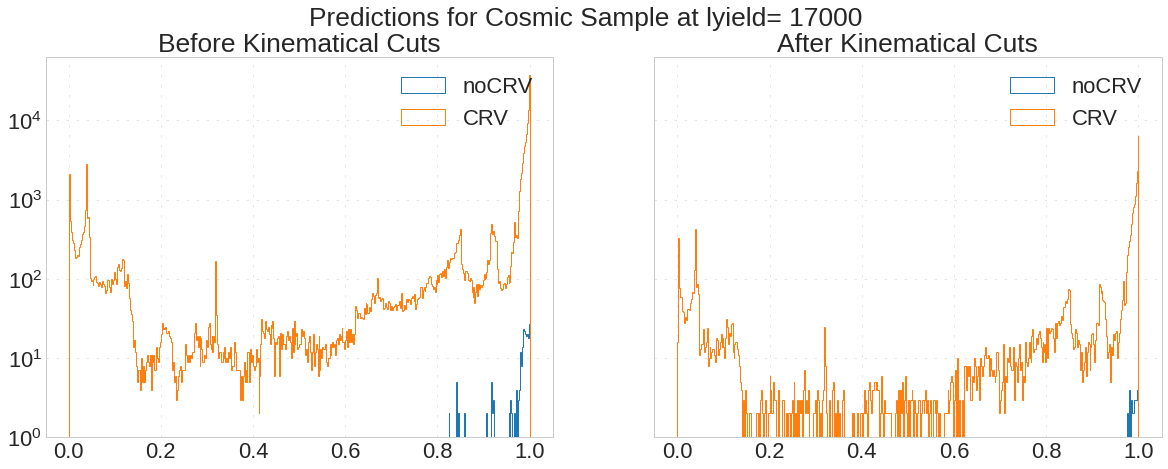

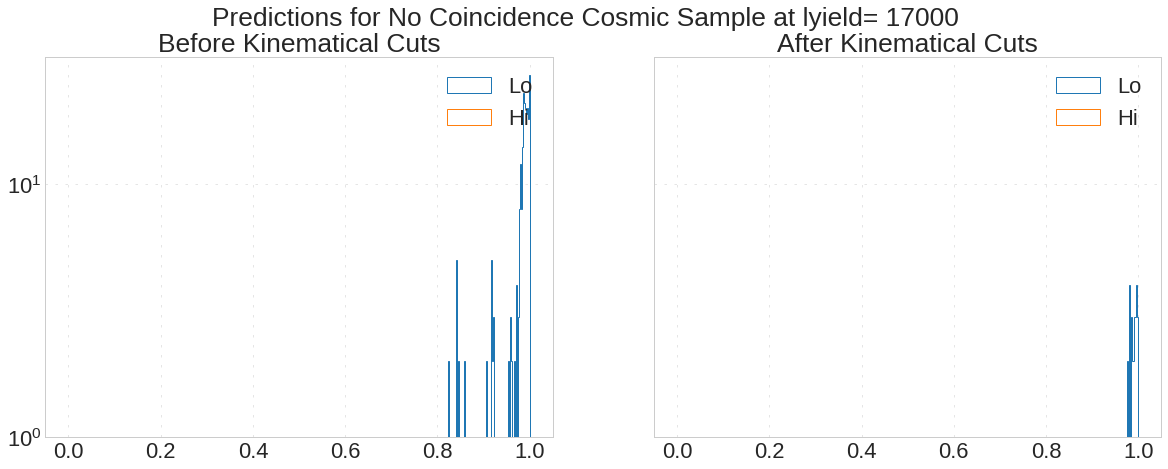

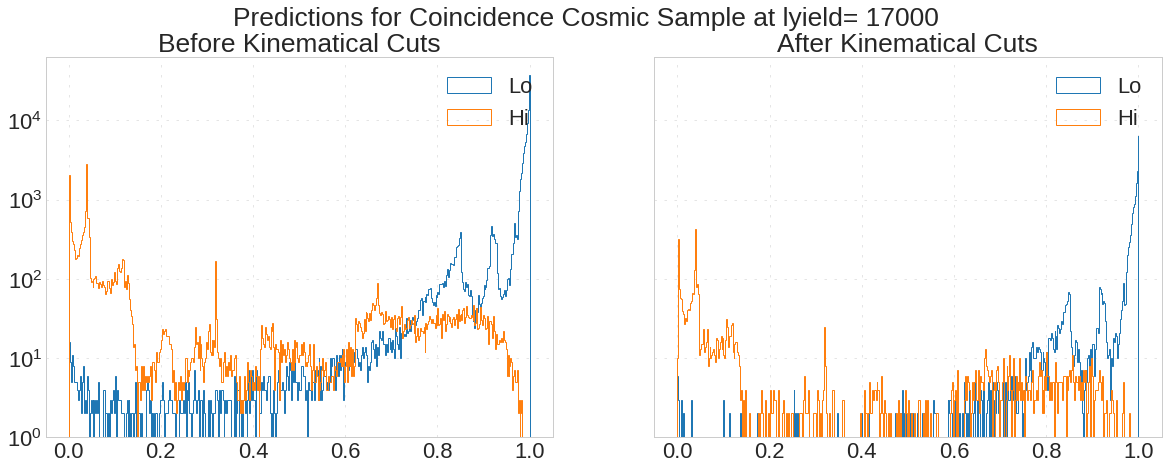

In [46]:
for i in yieldNums.keys():
  fig, ax = plt.subplots(1,2,figsize=(20,7), sharey=True)
  ax[1].hist(totalPredict.query(cut_extmom + ' and crvinfo__timeWindowStart < 0 and lyield==@i')["Predictions"], bins=500, histtype="step", label="noCRV", range=(0,1));
  ax[1].hist(totalPredict.query(cut_extmom + 'and crvinfo__timeWindowStart >= 0 and lyield==@i')["Predictions"], bins=500, histtype="step", label="CRV", range=(0,1));
  ax[1].set_yscale('log');
  ax[1].legend();
  ax[1].set_title("After Kinematical Cuts");
  ax[0].hist(totalPredict.query('crvinfo__timeWindowStart < 0 and lyield==@i')["Predictions"], bins=500, histtype="step", label="noCRV", range=(0,1));
  ax[0].hist(totalPredict.query('crvinfo__timeWindowStart >= 0 and lyield==@i')["Predictions"], bins=500, histtype="step", label="CRV", range=(0,1));
  ax[0].set_yscale('log');
  ax[0].legend();
  ax[0].set_title("Before Kinematical Cuts");
  ax[0].set_ylim(bottom=1);
  fig.suptitle("Predictions for Cosmic Sample at lyield= " + str(i));
  
  fig, ax = plt.subplots(1,2,figsize=(20,7), sharey=True)
  ax[1].hist(totalPredict.query(cut_extmom + ' and crvinfo__timeWindowStart < 0 and lyield==@i and is_high==0')["Predictions"], bins=500, histtype="step", label="Lo", range=(0,1));
  ax[1].hist(totalPredict.query(cut_extmom + ' and crvinfo__timeWindowStart < 0 and lyield==@i and is_high==1')["Predictions"], bins=500, histtype="step", label="Hi", range=(0,1));
  ax[1].set_yscale('log');
  ax[1].legend();
  ax[1].set_title("After Kinematical Cuts");
  ax[0].hist(totalPredict.query('crvinfo__timeWindowStart < 0 and lyield==@i and is_high==0')["Predictions"], bins=500, histtype="step", label="Lo", range=(0,1));
  ax[0].hist(totalPredict.query('crvinfo__timeWindowStart < 0 and lyield==@i and is_high==1')["Predictions"], bins=500, histtype="step", label="Hi", range=(0,1));
  ax[0].set_yscale('log');
  ax[0].legend();
  ax[0].set_title("Before Kinematical Cuts");
  ax[0].set_ylim(bottom=1);
  fig.suptitle("Predictions for No Coincidence Cosmic Sample at lyield= " + str(i));

  fig, ax = plt.subplots(1,2,figsize=(20,7), sharey=True)
  ax[1].hist(totalPredict.query(cut_extmom + ' and crvinfo__timeWindowStart >= 0 and lyield==@i and is_high==0')["Predictions"], bins=500, histtype="step", label="Lo", range=(0,1));
  ax[1].hist(totalPredict.query(cut_extmom + ' and crvinfo__timeWindowStart >= 0 and lyield==@i and is_high==1')["Predictions"], bins=500, histtype="step", label="Hi", range=(0,1));
  ax[1].set_yscale('log');
  ax[1].legend();
  ax[1].set_title("After Kinematical Cuts");
  ax[0].hist(totalPredict.query('crvinfo__timeWindowStart >= 0 and lyield==@i and is_high==0')["Predictions"], bins=500, histtype="step", label="Lo", range=(0,1));
  ax[0].hist(totalPredict.query('crvinfo__timeWindowStart >= 0 and lyield==@i and is_high==1')["Predictions"], bins=500, histtype="step", label="Hi", range=(0,1));
  ax[0].set_yscale('log');
  ax[0].legend();
  ax[0].set_title("Before Kinematical Cuts");
  ax[0].set_ylim(bottom=1);
  fig.suptitle("Predictions for Coincidence Cosmic Sample at lyield= " + str(i));
  plt.show();

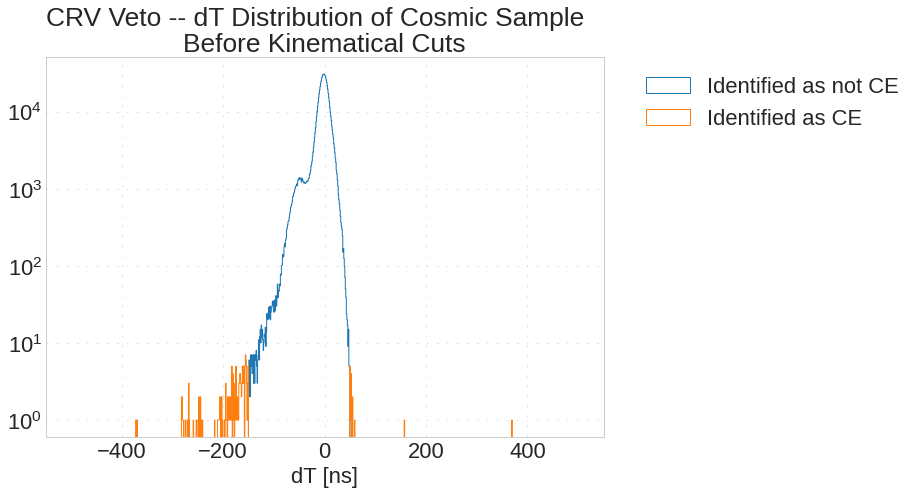

In [47]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.hist(totalPredict.query("not" + crv_time)['crvinfo__dT'], bins=1000, range=all_variables_list['crvinfo__dT'], histtype='step', label="Identified as not CE");
ax.hist(totalPredict.query(crv_time)['crvinfo__dT'], bins=1000, range=all_variables_list['crvinfo__dT'], histtype='step', label="Identified as CE");
fig.suptitle("CRV Veto -- dT Distribution of Cosmic Sample");
ax.set_title("Before Kinematical Cuts");
ax.set_xlabel("dT [ns]");
ax.set_yscale('log');
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left");

# ax[1].hist(totalPredict.query("not (" + cut_phymom + " & " + crv_time + ")")['crvinfo__dT'], bins=1000, range=all_variables_list['crvinfo__dT'], histtype='step', label="Identified as not CE");
# ax[1].hist(totalPredict.query(cut_phymom + "&" + crv_time)['crvinfo__dT'], bins=1000, range=all_variables_list['crvinfo__dT'], histtype='step', label="Identified as CE");
# ax[1].set_title("After Kinematical Cuts");
# ax[1].set_yscale('log');
# ax[1].set_xlabel("dT [ns]");
# ax[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left");

In [48]:
momscale = len(totalPredict.query(cut_extmom))/len(totalPredict.query(cut_phymom))
print(momscale)

13.272128155733549


In [61]:
noCRVpred = 0.5

In [62]:
bkgs = {}
for i in yieldNums.keys():
  for j in (0.01, 0.005, 0.001):
    afterCuts = totalPredict.query("lyield==@i & (" + cut_extmom + ")")
    bkg = Utils();
    bkgs[(i,j)] = (bkg.getNormBackground(afterCuts, '((Predictions < @j and crvinfo__timeWindowStart >=0) | (Predictions < @noCRVpred and crvinfo__timeWindowStart < 0))',momscale));
    bkgs[(i,"CRV")] = (bkg.getNormBackground(afterCuts, crv_time,momscale));

    # for k in all_variables_list.keys():
    #   fig, ax = plt.subplots(1,2,figsize=(25,7));

    #   ax[0].set_title("Identified as Not CE");
    #   ax[0].set_yscale('log');
    #   ax[0].hist(afterCuts.query('(Predictions > @j and crvinfo__timeWindowStart >=0) | (Predictions > @noCRVpred and crvinfo__timeWindowStart < 0)')[k], histtype='step', bins=50, range=all_variables_list[k], label="ML Veto");
    #   ax[0].hist(afterCuts.query("not (" + crv_time + ")")[k], histtype='step', bins=50, range=all_variables_list[k], label="CRV Veto");

    #   ax[1].set_title("Identified as CE");
    #   ax[1].set_yscale('log');
    #   ax[1].hist(afterCuts.query('(Predictions < @j and crvinfo__timeWindowStart >=0) | (Predictions < @noCRVpred and crvinfo__timeWindowStart < 0)')[k], histtype='step', bins=50, range=all_variables_list[k], label="ML Veto");
    #   ax[1].hist(afterCuts.query(crv_time)[k], histtype='step', bins=50, range=all_variables_list[k], label="CRV Veto");
    #   ax[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left");

    #   fig.suptitle("CRY4 Cosmic Sample: Lyield = "+str(i)+" Cutoff= " + str(j) +  " -- " + k);
    #   plt.show();

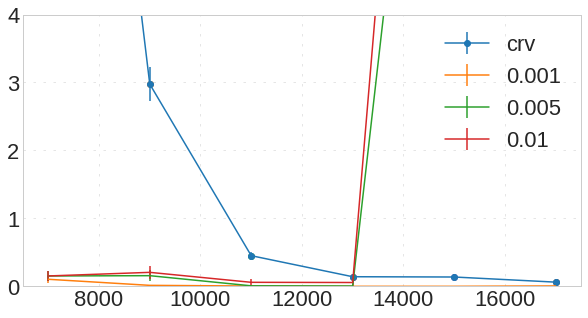

In [63]:
crvList = []
crverr = []
smallCutList = []
smallerr = []
medCutList = []
mederr = []
largeCutList = []
largerr = []
for i in yieldNums.keys():
  plt.scatter(i, bkgs[i,"CRV"][0])
  crvList.append(bkgs[i,"CRV"][0])
  crverr.append(bkgs[i,"CRV"][1])

  smallCutList.append(bkgs[i,0.001][0])
  smallerr.append(bkgs[i,0.001][1])

  medCutList.append(bkgs[i,0.005][0])
  mederr.append(bkgs[i,0.005][1])

  largeCutList.append(bkgs[i,0.01][0])
  largerr.append(bkgs[i,0.01][1])

plt.ylim(0,4);
plt.errorbar(yieldNums.keys(), crvList, yerr=crverr, marker='o', label='crv');
plt.errorbar(yieldNums.keys(), smallCutList, yerr=smallerr, label='0.001');
plt.errorbar(yieldNums.keys(), medCutList, yerr=mederr, label='0.005');
plt.errorbar(yieldNums.keys(), largeCutList, yerr=largerr, label='0.01');
plt.legend();


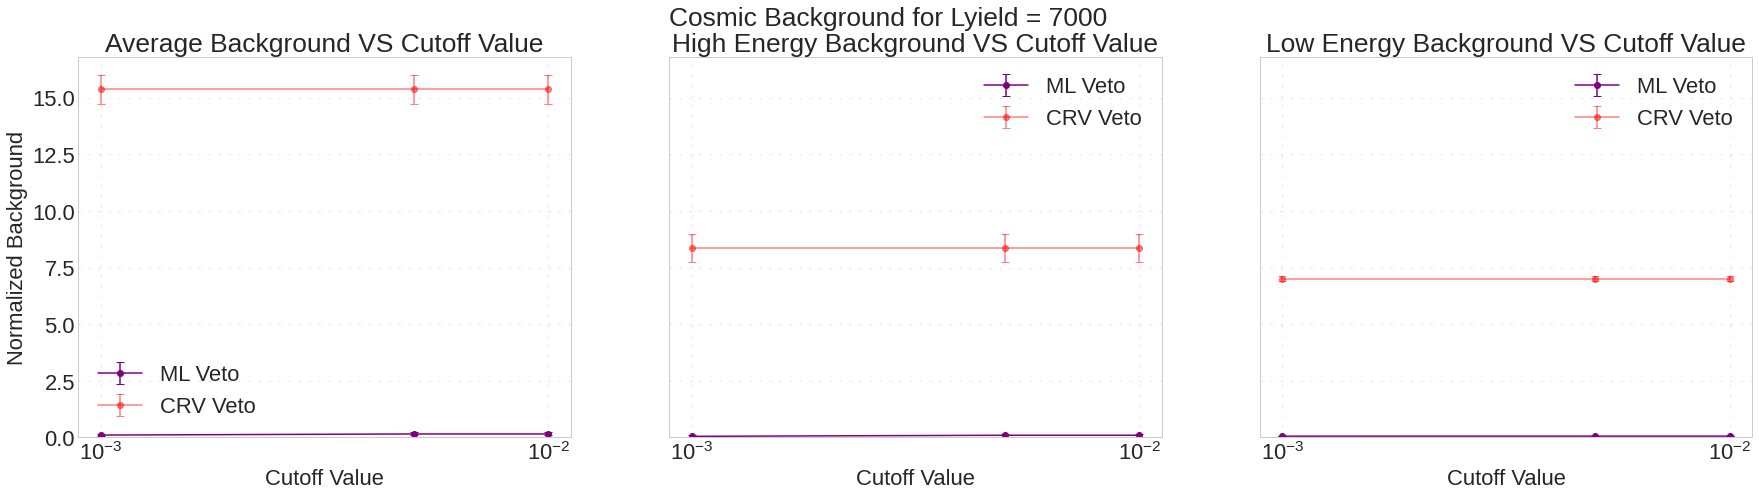

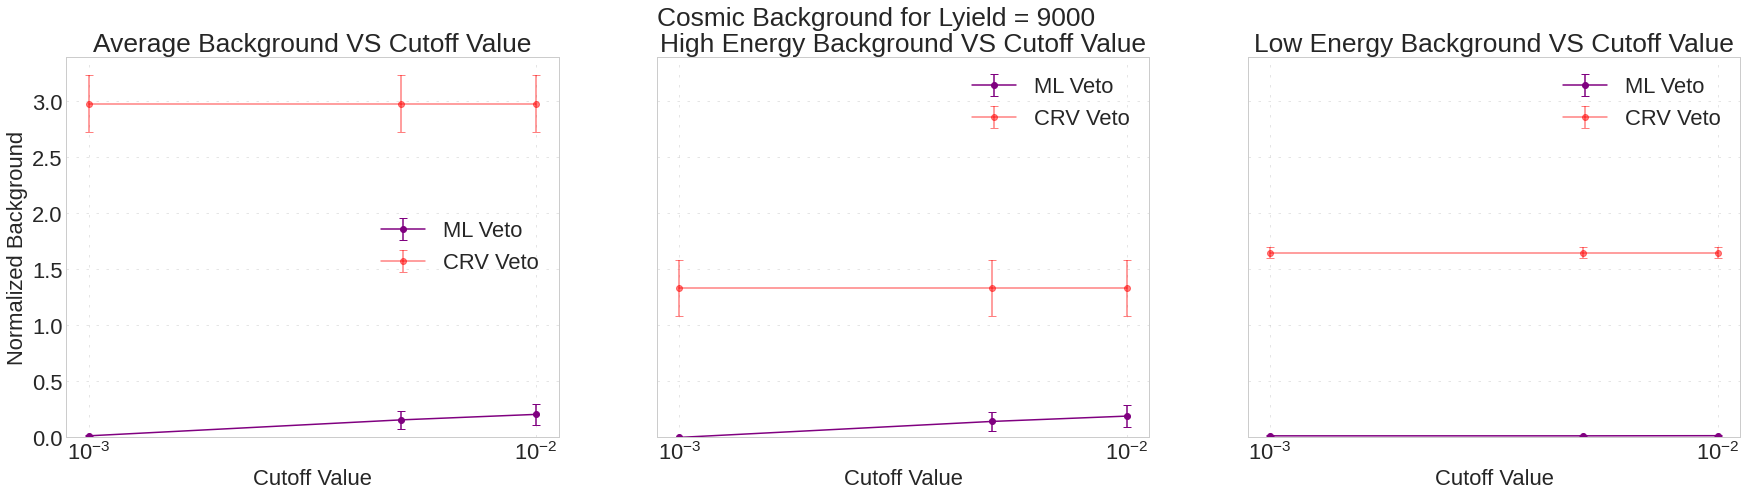

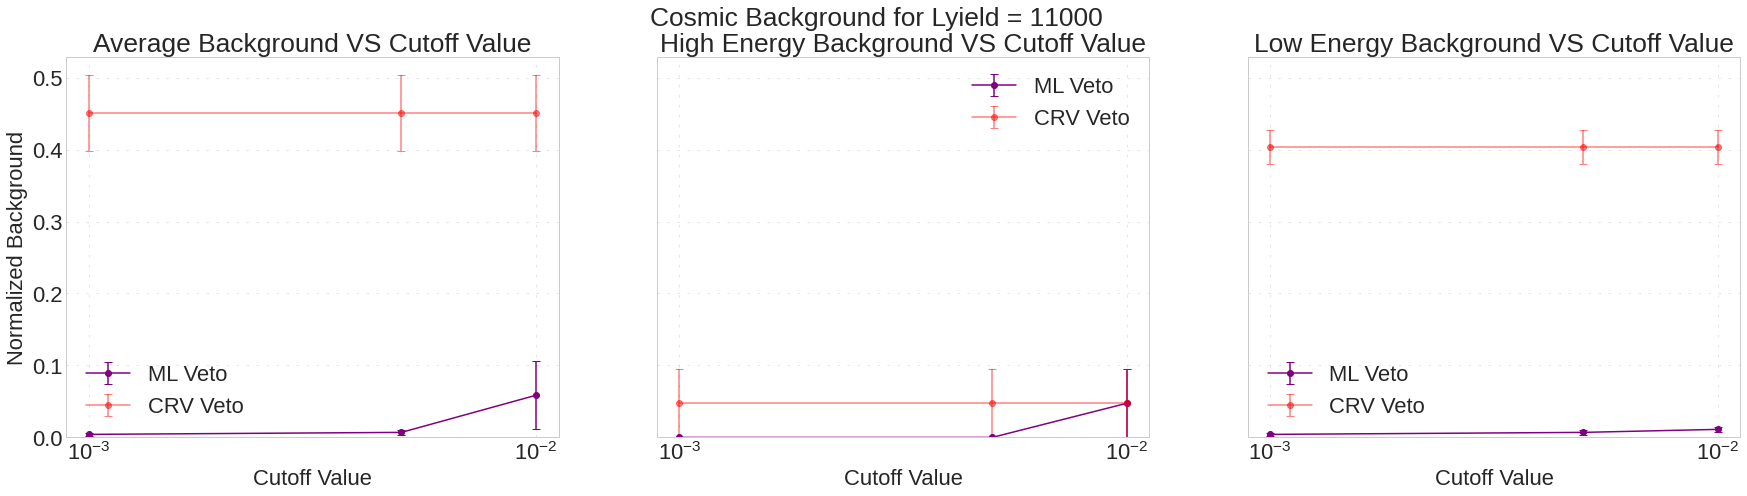

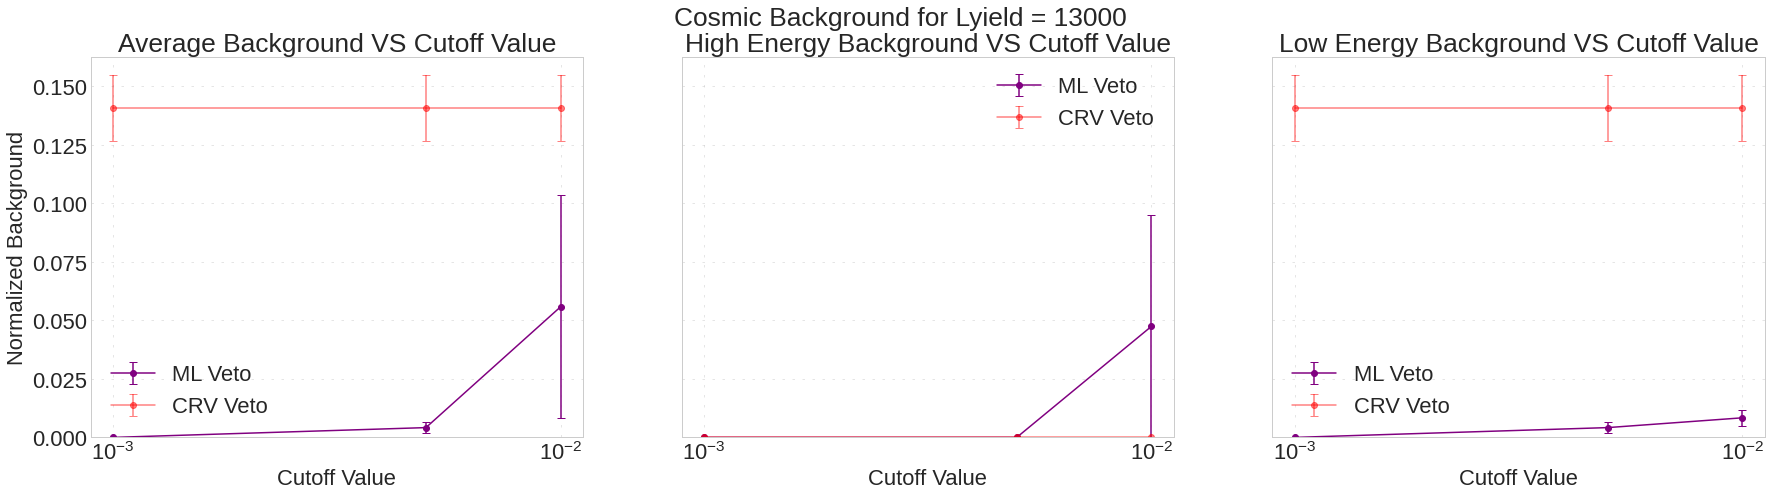

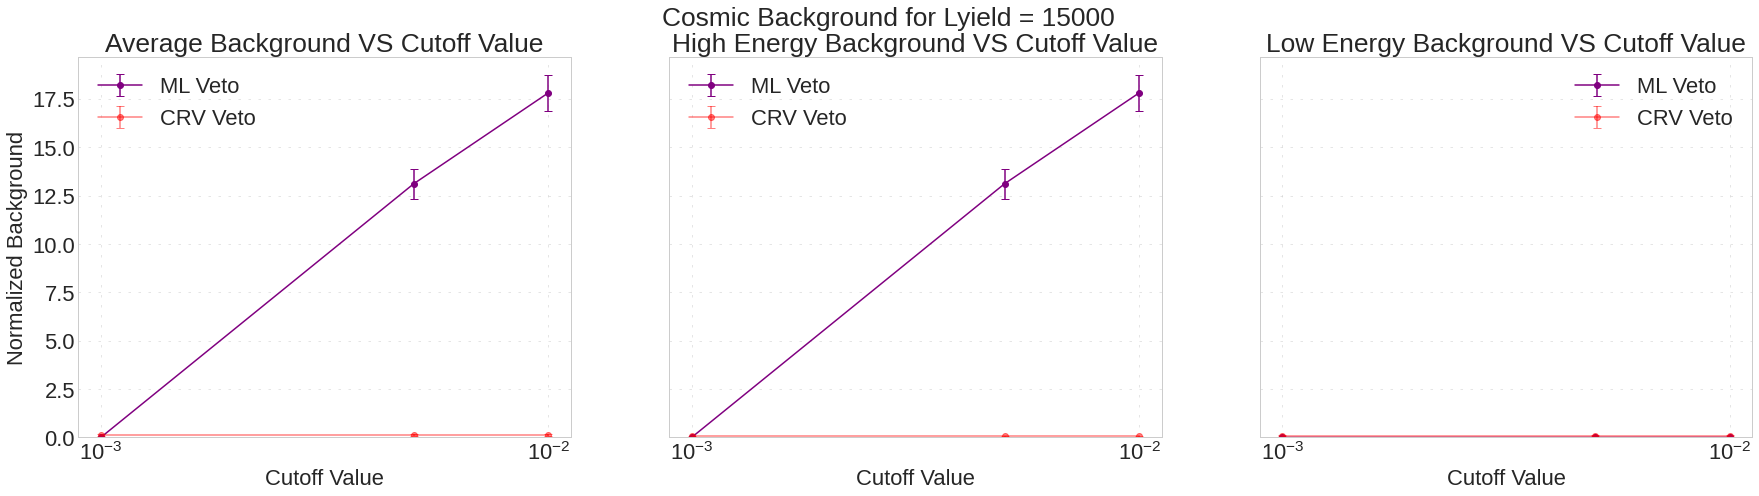

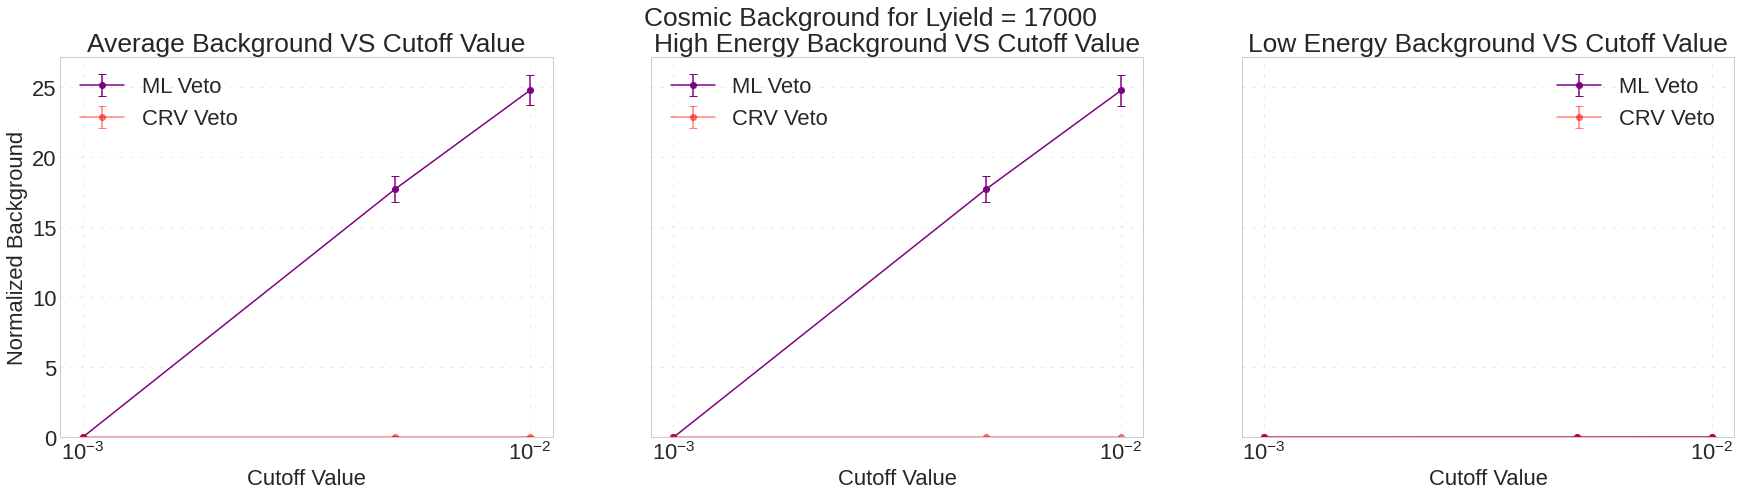

In [64]:
for i in yieldNums.keys(): #ave, err, ave_hi, ave_lo, err_hi, err_lo
  fig, ax = plt.subplots(1,3,figsize=(30,7), sharey=True); #ave, err, ave_hi, ave_lo, err_hi, err_lo
  ax[0].errorbar((0.01, 0.005, 0.001), (bkgs[(i,0.01)][0], bkgs[(i,0.005)][0], bkgs[(i,0.001)][0]), yerr=(bkgs[(i,0.01)][1], bkgs[(i,0.005)][1], bkgs[(i,0.001)][1]), marker='o', capsize=4, label='ML Veto', color="purple");
  ax[0].errorbar((0.01, 0.005, 0.001), (bkgs[(i,"CRV")][0], bkgs[(i,"CRV")][0], bkgs[(i,"CRV")][0]), yerr=(bkgs[(i,"CRV")][1], bkgs[(i,"CRV")][1], bkgs[(i,"CRV")][1]), marker='o', capsize=4, label='CRV Veto', alpha=0.5, color="red");

  ax[0].set_title("Average Background VS Cutoff Value");
  ax[0].set_xscale('log');
  ax[0].set_ylabel('Normalized Background');
  ax[0].set_xlabel('Cutoff Value');
  ax[0].legend(loc="best");
  ax[0].set_ylim(bottom=0)

  ax[1].errorbar((0.01, 0.005, 0.001), (bkgs[(i,0.01)][2], bkgs[(i,0.005)][2], bkgs[(i,0.001)][2]), yerr=(bkgs[(i,0.01)][4], bkgs[(i,0.005)][4], bkgs[(i,0.001)][4]), marker='o', capsize=4, label='ML Veto', color='purple');
  ax[1].errorbar((0.01, 0.005, 0.001), (bkgs[(i,"CRV")][2], bkgs[(i,"CRV")][2], bkgs[(i,"CRV")][2]), yerr=(bkgs[(i,"CRV")][4], bkgs[(i,"CRV")][4], bkgs[(i,"CRV")][4]), marker='o', capsize=4, label='CRV Veto', alpha=0.5,color='red');
  ax[1].set_title("High Energy Background VS Cutoff Value")
  ax[1].legend(loc="best");
  ax[1].set_xscale('log');
  ax[1].set_xlabel('Cutoff Value');

  ax[2].errorbar((0.01, 0.005, 0.001), (bkgs[(i,0.01)][3], bkgs[(i,0.005)][3], bkgs[(i,0.001)][3]), yerr=(bkgs[(i,0.01)][5], bkgs[(i,0.005)][5], bkgs[(i,0.001)][5]), marker='o', capsize=4, label='ML Veto', color='purple');
  ax[2].errorbar((0.01, 0.005, 0.001), (bkgs[(i,"CRV")][3], bkgs[(i,"CRV")][3], bkgs[(i,"CRV")][3]), yerr=(bkgs[(i,"CRV")][5], bkgs[(i,"CRV")][5], bkgs[(i,"CRV")][5]), marker='o', capsize=4, label='CRV Veto',alpha=0.5, color='red');
  ax[2].set_title("Low Energy Background VS Cutoff Value")
  ax[2].legend(loc="best");
  ax[2].set_xscale('log');
  ax[2].set_xlabel('Cutoff Value');

  fig.suptitle("Cosmic Background for Lyield = " + str(i));
  plt.show();

#Load CE Test Sample (Don't run if loading predictions)

In [49]:
fileopener = open(main_path+"Saved_Data/CoincidenceTestingCE.pkl", "rb")
CRV_y_test, CRV_X_test_df = pickle.load(fileopener)

In [50]:
fileopener = open(main_path+"Saved_Data/noCoincidenceTestingCE.pkl", "rb")
noCRV_y_test, noCRV_X_test_df = pickle.load(fileopener)

#Predict CE Test Sample (Don't run if loading predictions)

In [51]:
CRV_X_test_df[list(dTZPE_noMom_variables_list.keys())] = CRVscaler.transform(CRV_X_test_df[list(dTZPE_noMom_variables_list.keys())])
CRV_X_test_df['Predictions'] = cinnamonBagel.model.predict(CRV_X_test_df[list(dTZPE_noMom_variables_list.keys())])
CRV_X_test_df[list(dTZPE_noMom_variables_list.keys())] = CRVscaler.inverse_transform(CRV_X_test_df[list(dTZPE_noMom_variables_list.keys())])

In [52]:
noCRV_X_test_df[list(noCRV_noMom_variables_list.keys())] = noCRVscaler.transform(noCRV_X_test_df[list(noCRV_noMom_variables_list.keys())])
noCRV_X_test_df['Predictions'] = plainBagel.model.predict(noCRV_X_test_df[list(noCRV_noMom_variables_list.keys())])
noCRV_X_test_df[list(noCRV_noMom_variables_list.keys())] = noCRVscaler.inverse_transform(noCRV_X_test_df[list(noCRV_noMom_variables_list.keys())])

In [ ]:
CETestSample = CRV_X_test_df.append(noCRV_X_test_df)
CETestSample.to_hdf(main_path+"Saved_Data/CETestSample.h5", 'df')

In [ ]:
del CRV_X_test_df, noCRV_X_test_df

#Load Predicted Data

In [ ]:
CETestSample = pd.read_hdf(main_path+"Saved_Data/CETestSample.h5", key='df',mode='r')

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


#CE Sample Analysis

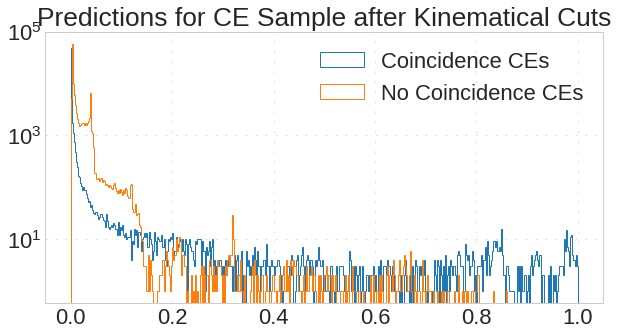

In [54]:
plt.hist(CETestSample.query('crvinfo__PEs >= -1 & (' + cut_phymom + ')', engine='python')["Predictions"], bins=500, histtype="step", label="Coincidence CEs", range=(0,1));
plt.hist(CETestSample.query('crvinfo__PEs < -1 & (' + cut_phymom + ')', engine='python')["Predictions"], bins=500, histtype="step", label="No Coincidence CEs", range=(0,1));
plt.yscale('log');
plt.legend();
plt.title("Predictions for CE Sample after Kinematical Cuts");

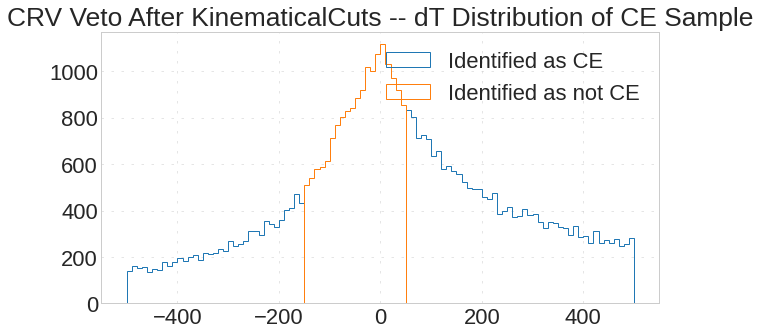

In [ ]:
plt.hist(CETestSample.query(cut_phymom + "&" + crv_time)['crvinfo__dT'], bins=100, range=all_variables_list['crvinfo__dT'], histtype='step', label="Identified as CE");
plt.hist(CETestSample.query(cut_phymom + "& not" + crv_time)['crvinfo__dT'], bins=100, range=all_variables_list['crvinfo__dT'], histtype='step', label="Identified as not CE");
plt.title("CRV Veto After KinematicalCuts -- dT Distribution of CE Sample");
plt.legend();

In [ ]:
for j in (0.01, 0.005, 0.001):
  afterCuts = CETestSample.query("(" + cut_phymom + ")")
  for k in all_variables_list.keys():
    fig, ax = plt.subplots(1,2,figsize=(25,7));

    ax[0].set_title("Identified as Not CE");
    ax[0].set_yscale('log');
    ax[0].hist(afterCuts.query("(Predictions > @j and crvinfo__timeWindowStart >=0) | (Predictions > @noCRVpred and crvinfo__timeWindowStart < 0 )")[k], histtype='step', bins=50, range=all_variables_list[k], label="ML Veto");
    ax[0].hist(afterCuts.query("not" + crv_time)[k], histtype='step', bins=50, range=all_variables_list[k], label="CRV Veto");
    ax[0].set_ylim(bottom=1)

    ax[1].set_title("Identified as CE");
    ax[1].set_yscale('log');
    ax[1].hist(afterCuts.query("(Predictions < @j and crvinfo__timeWindowStart >=0) | (Predictions < @noCRVpred and crvinfo__timeWindowStart < 0 )")[k], histtype='step', bins=50, range=all_variables_list[k], label="ML Veto");
    ax[1].hist(afterCuts.query(crv_time)[k], histtype='step', bins=50, range=all_variables_list[k], label="CRV Veto");
    ax[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left");
    ax[1].set_ylim(bottom=1)

    fig.suptitle("CE Sample: Cutoff= " + str(j) +  " -- " + k);
    plt.show();

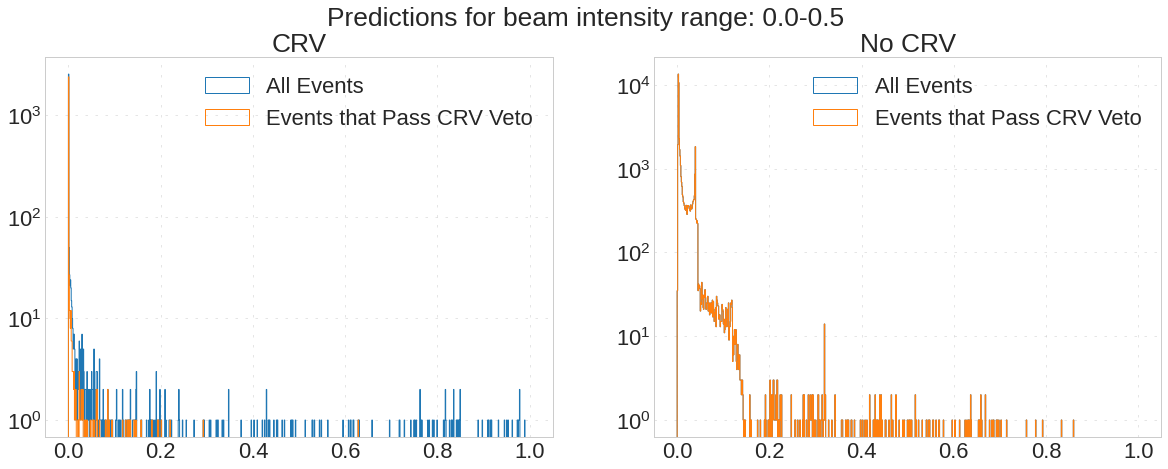

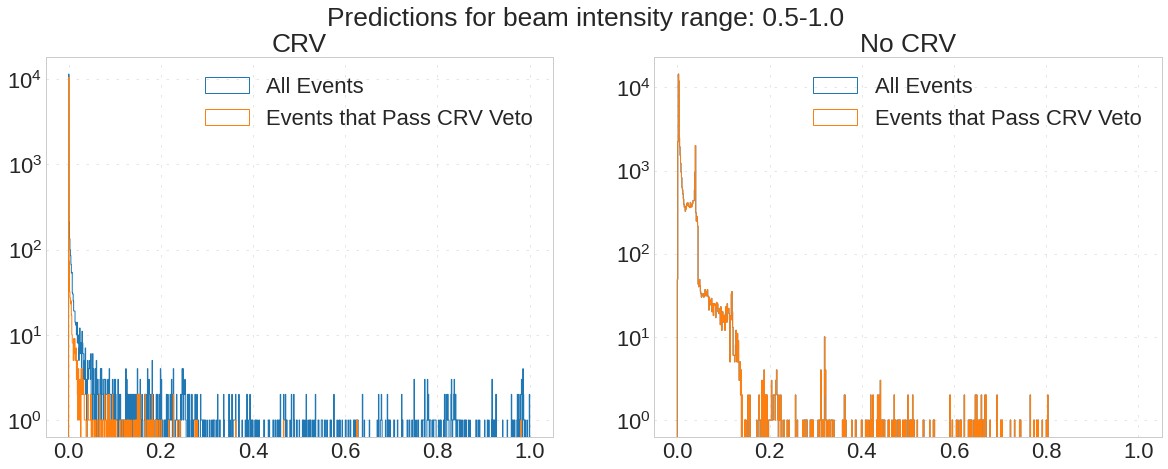

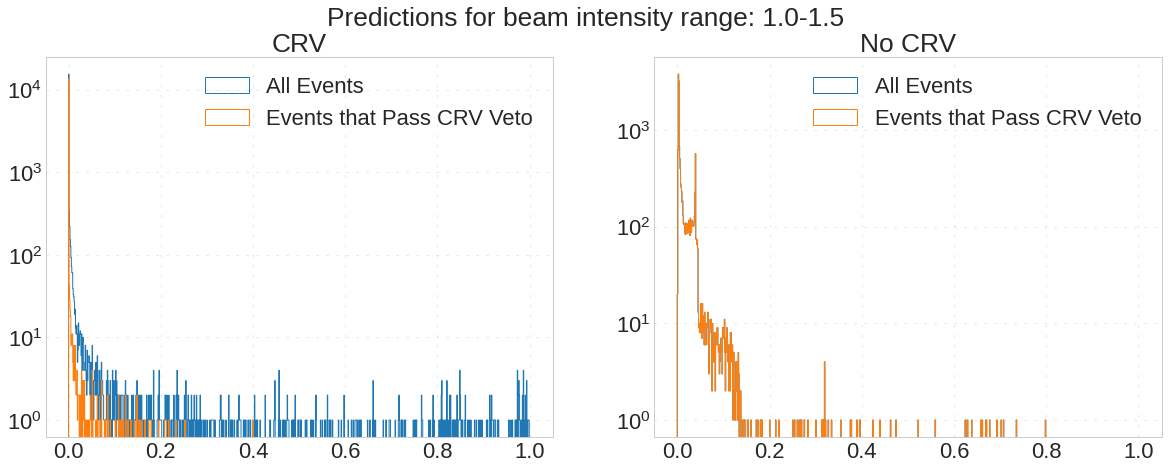

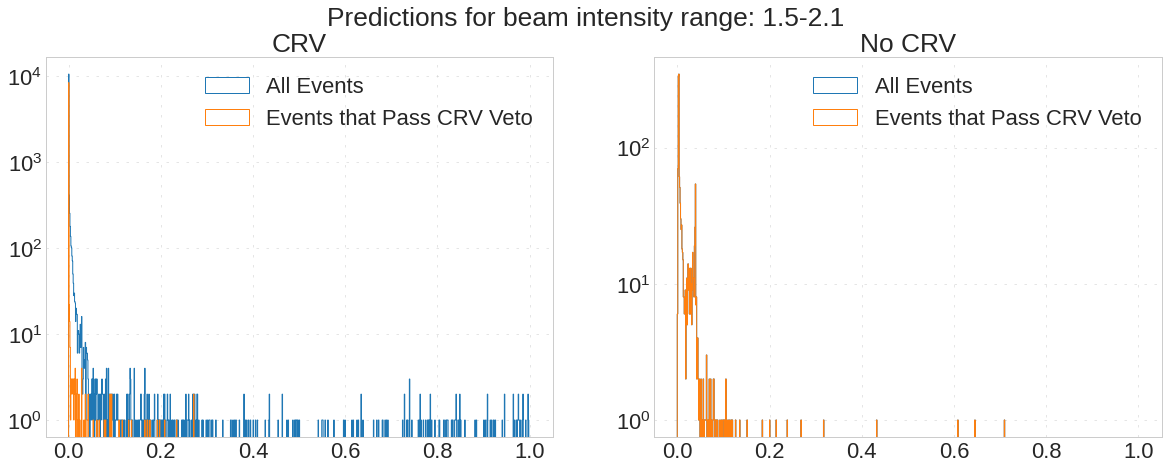

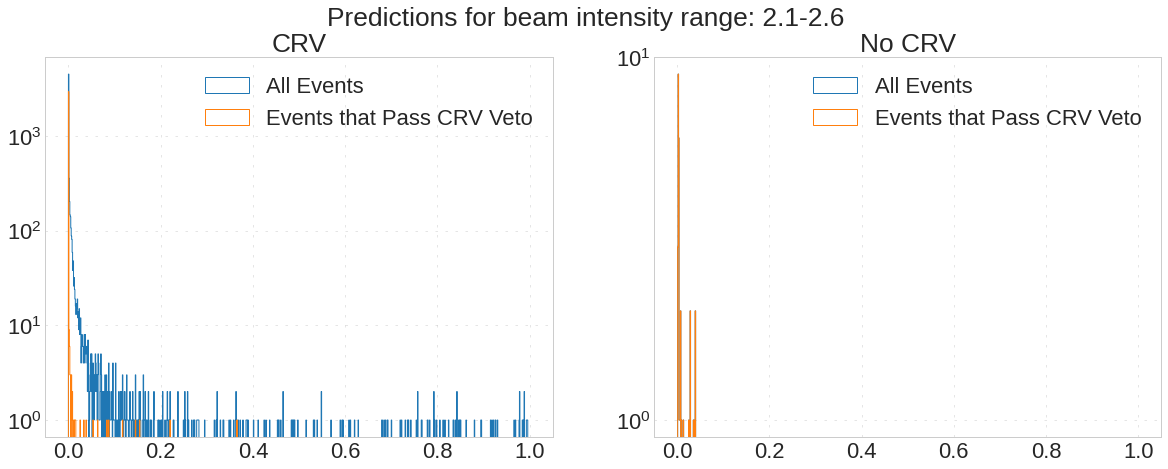

In [55]:
deadtimes = []
beamranges = [(0,0.2e8), (0.2e8,0.4e8), (0.4e8,0.6e8), (0.6e8,0.8e8), (0.8e8,1e8)]
cutoffs = ["ML: cutoff=0.001", "ML: cutoff=0.005", "ML: cutoff=0.01", "CRV"]
for i in (beamranges):
  afterCuts = CETestSample.query("(evtinfo__nprotons > @i[0] and evtinfo__nprotons < @i[1]) and (" + cut_phymom + ")")
  nums = np.array((len(afterCuts.query('(Predictions < 0.001 and crvinfo__timeWindowStart >=0) | (Predictions < @noCRVpred and crvinfo__timeWindowStart < 0)')), 
                   len(afterCuts.query('(Predictions < 0.005 and crvinfo__timeWindowStart >=0) | (Predictions < @noCRVpred and crvinfo__timeWindowStart < 0)')), 
                   len(afterCuts.query('(Predictions < 0.01 and crvinfo__timeWindowStart >=0) | (Predictions < @noCRVpred and crvinfo__timeWindowStart < 0)')),
                   len(afterCuts.query(crv_time))))
  nums = 1 - nums/len(afterCuts);
  deadtimes.append(nums)
  fig, ax = plt.subplots(1,2, figsize=(20,7))
  ax[0].hist(afterCuts.query("crvinfo__timeWindowStart >=0")["Predictions"], histtype='step', range=(0,1), bins=1000, label="All Events");
  ax[0].hist(afterCuts.query("crvinfo__timeWindowStart >=0 and " + crv_time)["Predictions"], histtype='step', bins=1000, range=(0,1), label="Events that Pass CRV Veto");
  ax[0].set_yscale('log');
  ax[0].set_title("CRV");
  ax[0].legend(loc="best");
  ax[1].hist(afterCuts.query("crvinfo__timeWindowStart <0")["Predictions"], histtype='step', range=(0,1), bins=1000, label="All Events");
  ax[1].hist(afterCuts.query("crvinfo__timeWindowStart <0 and " + crv_time)["Predictions"], histtype='step', bins=1000, range=(0,1), label='Events that Pass CRV Veto');
  ax[1].set_yscale('log');
  ax[1].set_title("No CRV");
  ax[1].legend(loc="best");
  fig.suptitle("Predictions for beam intensity range: " + str(round(i[0]/3.9e7,1)) + "-" + str(round(i[1]/3.9e7,1)));

deadtimes = np.array(deadtimes)

In [56]:
for n,i in enumerate(beamranges):
  beamranges[n] = np.mean(i)

In [57]:
beamranges = np.array(beamranges)/(3.9e7)

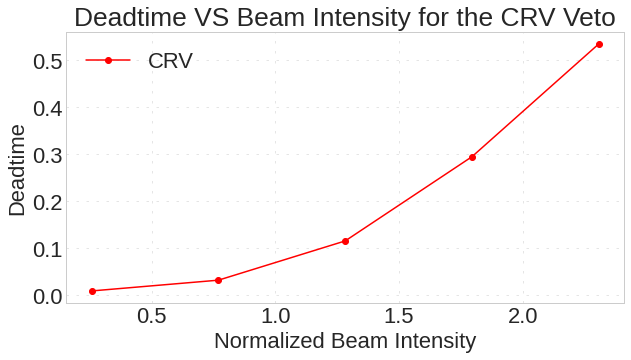

In [58]:
plt.plot(beamranges, deadtimes[:,-1], label=cutoffs[-1], marker='o', color='red');
plt.xlabel("Normalized Beam Intensity");
plt.ylabel("Deadtime");
plt.title("Deadtime VS Beam Intensity for the CRV Veto")
plt.legend();

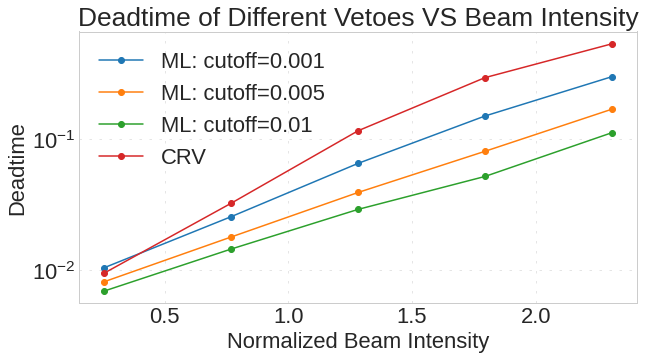

In [59]:
for i in range(4):
  plt.plot(beamranges, deadtimes[:,i], label=cutoffs[i], marker='o');
plt.yscale('log');
plt.xlabel("Normalized Beam Intensity");
plt.ylabel("Deadtime");
plt.title("Deadtime of Different Vetoes VS Beam Intensity")
plt.legend();

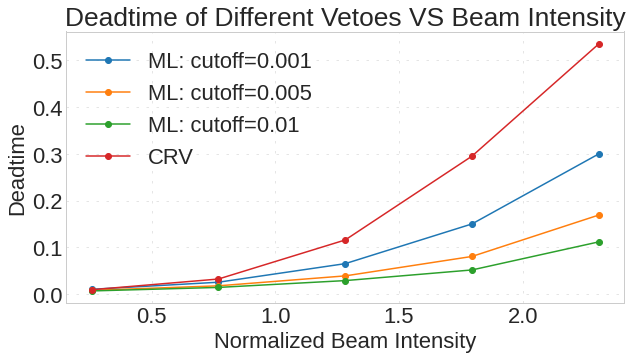

In [60]:
for i in range(4):
  plt.plot(beamranges, deadtimes[:,i], label=cutoffs[i], marker='o');
plt.xlabel("Normalized Beam Intensity");
plt.ylabel("Deadtime");
plt.title("Deadtime of Different Vetoes VS Beam Intensity")
plt.legend();

[0.07003852 0.04480562 0.0324383 ]
CRV: 0.09280243651184661


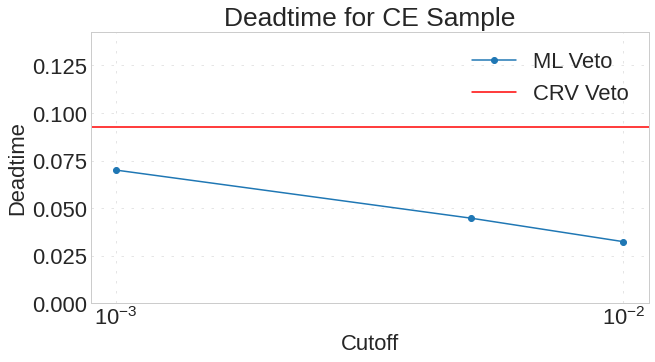

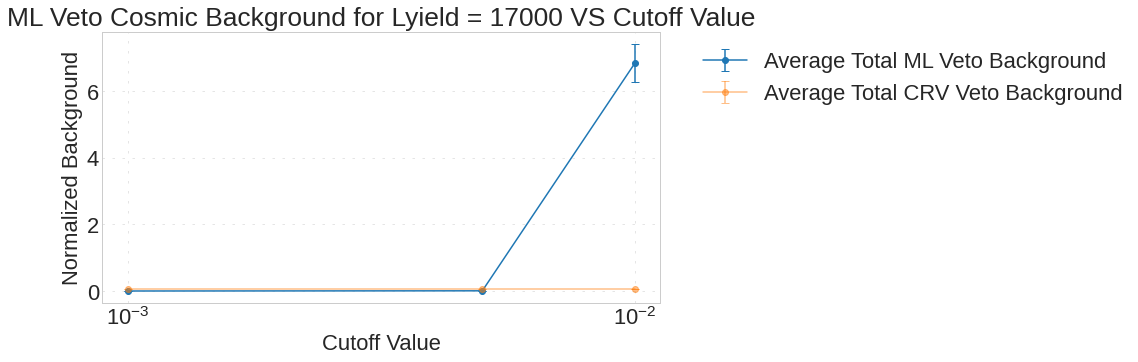

In [ ]:
afterCuts = CETestSample.query(cut_phymom)
nums = np.array((len(afterCuts.query('(Predictions < 0.001 and crvinfo__timeWindowStart >=0) | (Predictions < @noCRVpred and crvinfo__timeWindowStart < 0)')), len(afterCuts.query('(Predictions < 0.005 and crvinfo__timeWindowStart >=0) | (Predictions < @noCRVpred and crvinfo__timeWindowStart < 0)')), len(afterCuts.query('(Predictions < 0.01 and crvinfo__timeWindowStart >=0) | (Predictions < @noCRVpred and crvinfo__timeWindowStart < 0)'))));
nums = 1 - nums/len(afterCuts);
print(nums)
plt.plot((0.001, 0.005, 0.01), nums, label="ML Veto", marker='o');
crvDeadtime = 1 - len(afterCuts.query(crv_time))/len(afterCuts)
print("CRV:", crvDeadtime)
plt.gca().axhline(crvDeadtime,0,1, color="red", label="CRV Veto");
plt.ylim(top=crvDeadtime+0.05, bottom=0)
plt.legend();
plt.title("Deadtime for CE Sample");
plt.ylabel("Deadtime");
plt.xlabel("Cutoff");
plt.xscale('log');

plt.figure(); #ave, err, ave_hi, ave_lo, err_hi, err_lo
i=17000
plt.errorbar((0.01, 0.005, 0.001), (bkgs[(i,0.01)][0], bkgs[(i,0.005)][0], bkgs[(i,0.001)][0]), yerr=(bkgs[(i,0.01)][1], bkgs[(i,0.005)][1], bkgs[(i,0.001)][1]), marker='o', capsize=4, label='Average Total ML Veto Background');
plt.errorbar((0.01, 0.005, 0.001), (bkgs[(i,"CRV")][0], bkgs[(i,"CRV")][0], bkgs[(i,"CRV")][0]), yerr=(bkgs[(i,"CRV")][1], bkgs[(i,"CRV")][1], bkgs[(i,"CRV")][1]), marker='o', capsize=4, label='Average Total CRV Veto Background', alpha=0.5);
plt.legend();

plt.title("ML Veto Cosmic Background for Lyield = " + str(i) + " VS Cutoff Value");
plt.xscale('log');
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
plt.ylabel('Normalized Background');
plt.xlabel('Cutoff Value');
plt.show();

#Cutoff Analysis

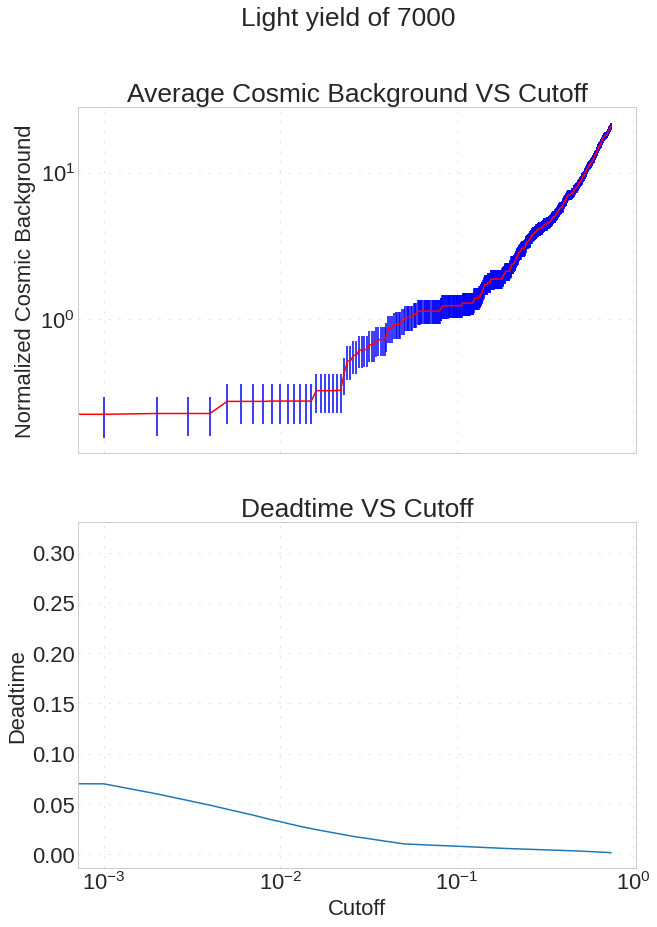

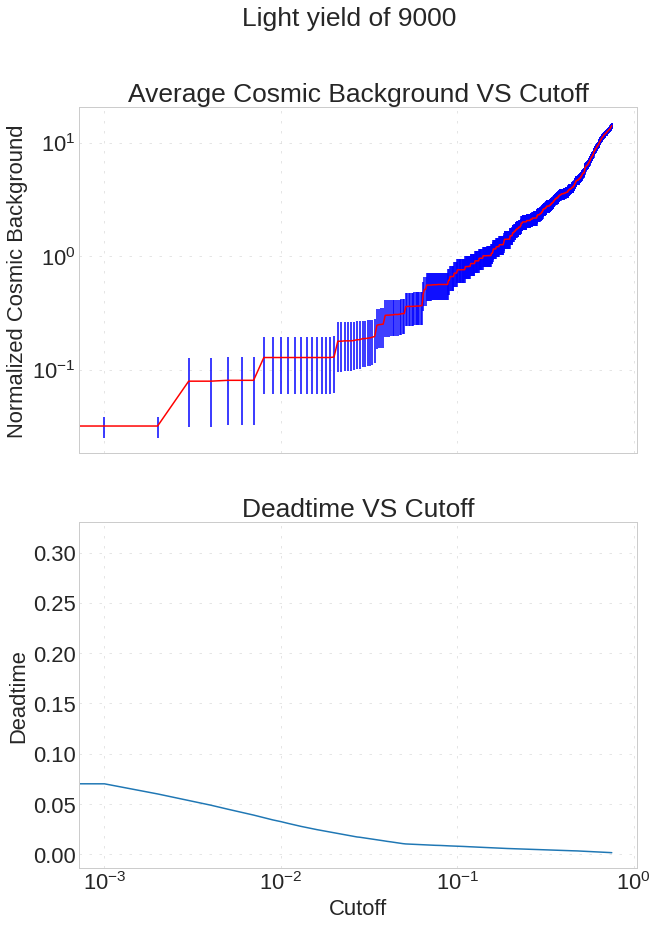

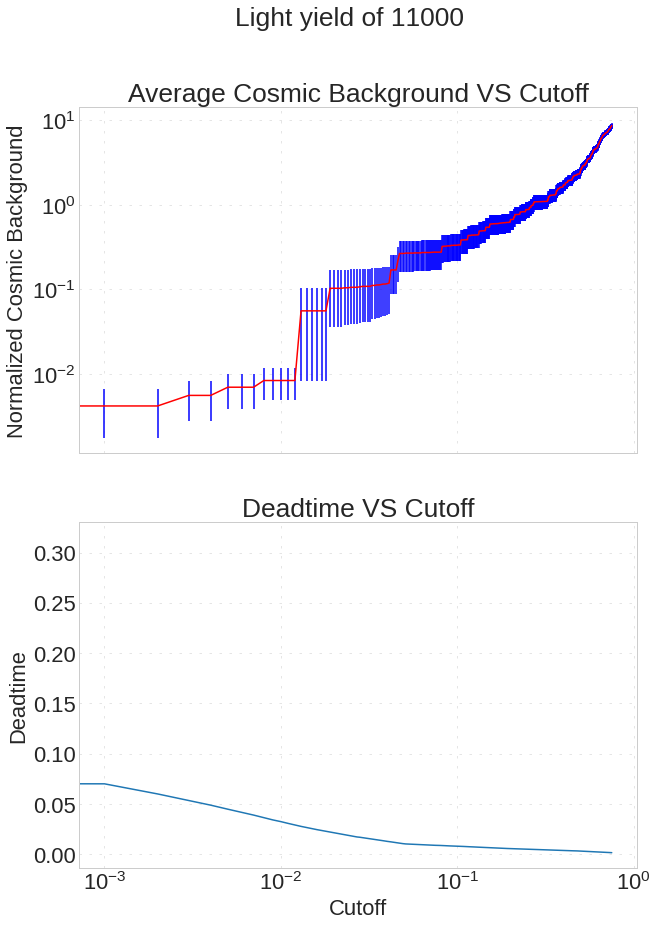

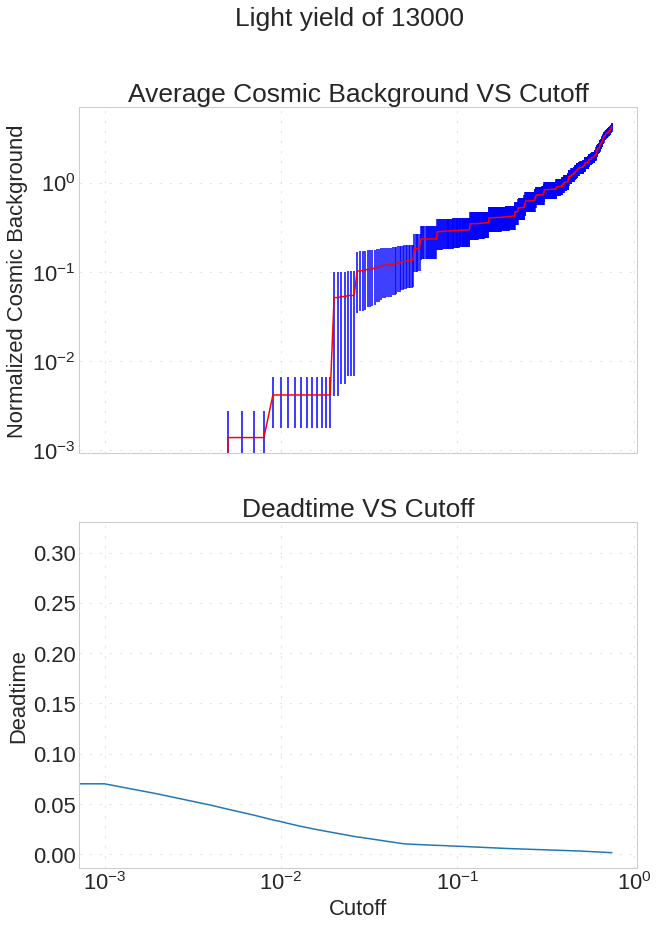

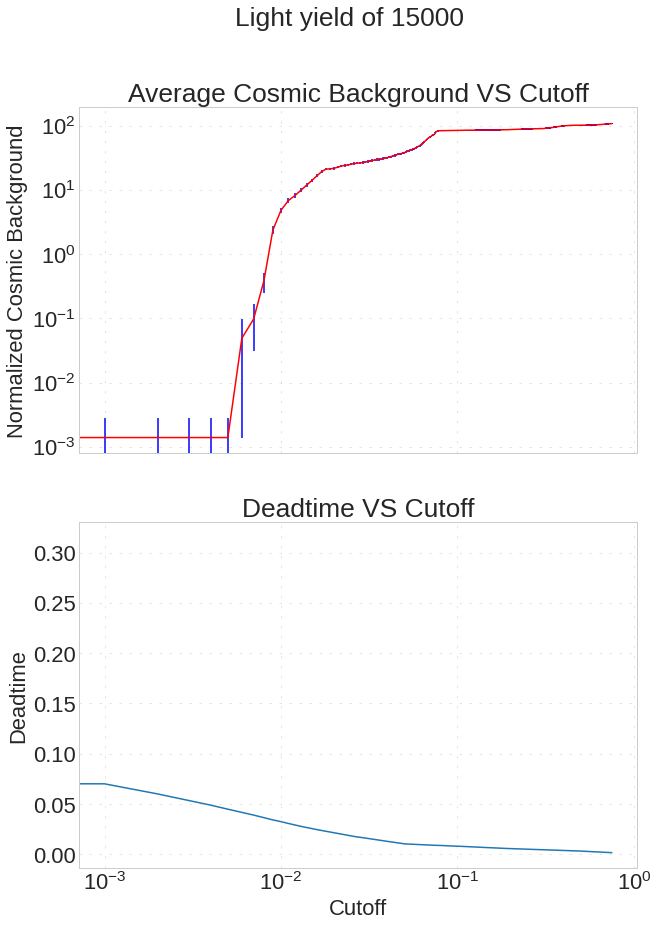

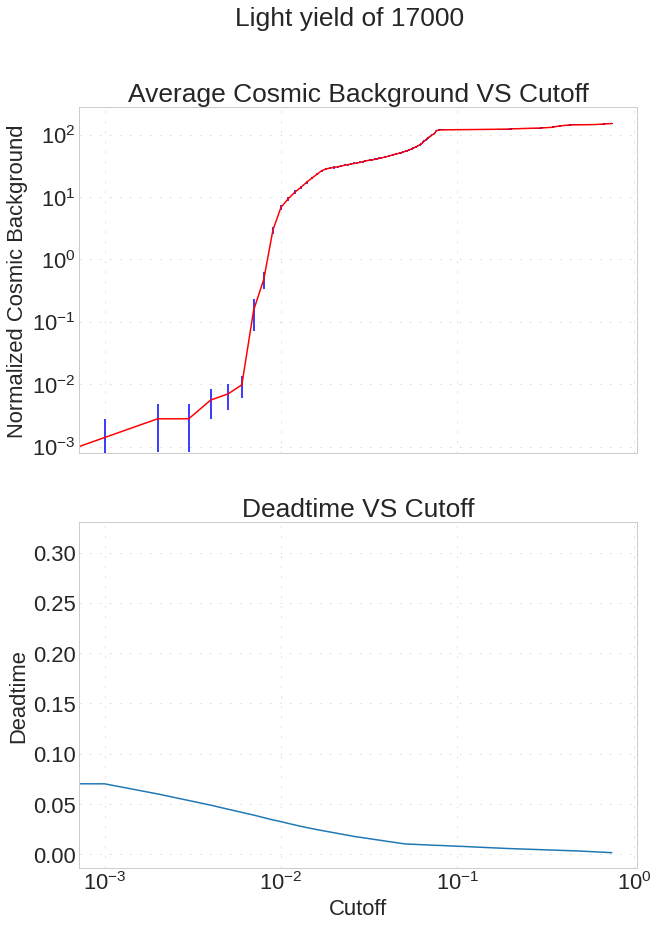

In [ ]:
for light in yieldNums.keys():
  bkg = Utils()
  momscale = len(totalPredict.query(cut_extmom))/len(totalPredict.query(cut_phymom))
  cosmic = totalPredict.query(cut_extmom + "& lyield==@light")
  ce = CETestSample.query(cut_phymom)

  cosmoVal = []
  cosmoErr = []
  dtime = []
  x = np.arange(0.75,-0.001,-0.001)
  for i in x:
    bkgCalc = bkg.getNormBackground(cosmic, '((Predictions < @i and crvinfo__timeWindowStart >=0) | (Predictions < @noCRVpred and crvinfo__timeWindowStart < 0))', momscale)
    cosmoVal.append(bkgCalc[0])
    cosmoErr.append(bkgCalc[1])

    dtime.append( 1- (len(ce.query('((Predictions < @i and crvinfo__timeWindowStart >=0) | (Predictions < @noCRVpred and crvinfo__timeWindowStart < 0))'))/len(ce)) )

  fig, ax = plt.subplots(2,1, figsize=(10,14), sharex=True)
  ax[0].errorbar(x, cosmoVal, yerr=cosmoErr, color='red',ecolor='blue');
  ax[0].set_title("Average Cosmic Background VS Cutoff");
  ax[0].set_ylabel("Normalized Cosmic Background");
  ax[0].set_yscale('log');
  ax[1].plot(x, dtime);
  ax[1].set_title("Deadtime VS Cutoff");
  ax[1].set_xlabel("Cutoff");
  ax[1].set_ylabel("Deadtime");
  ax[1].set_xscale('log');
  fig.suptitle("Light yield of " + str(light))
  # plt.tight_layout();
  plt.show();
